# Import modules

In [1]:
import csv
import os
import pickle
import pytz
import torch
import timeit
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from copy import deepcopy
from datetime import datetime
from einops import rearrange
from itertools import chain
from time import time
from torch import nn, optim
from torchmetrics.classification import MulticlassAccuracy, MulticlassF1Score, MulticlassConfusionMatrix
from torch.optim import lr_scheduler
from tqdm.notebook import tqdm
from torch.utils.data import TensorDataset, DataLoader
from polyglot.mapping import Embedding, CaseExpander, DigitExpander

# Hyperparameters

In [2]:
class Hyperparams:
     def __init__(
        self,
        context_size=10,
        fold=3,
        max_seq_len=82,
        input_size=64,
        batch_size=32,
        num_hidden_layer=1,
        hidden_size=128,
        dropout=0,
        bias=True,
        output_size=24,
        shuffle=True,
        lr=0.005,
        batch_first=False,
        bidirectional=True,
        init_wb_with_kaiming_normal=True,
        n_epoch=50,
        patience=50,
        device="cuda" if torch.cuda.is_available() else "cpu"
    ):
        self.context_size = context_size
        self.fold = fold
        self.input_size = input_size
        self.max_seq_len = max_seq_len
        self.batch_size = batch_size
        self.num_hidden_layer = num_hidden_layer
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.bias = bias
        self.output_size = output_size
        self.shuffle = shuffle
        self.lr = lr
        self.batch_first = batch_first
        self.bidirectional = bidirectional
        self.init_wb_with_kaiming_normal = init_wb_with_kaiming_normal
        self.n_epoch = n_epoch
        self.patience = patience
        self.device = device

hyperparams = Hyperparams()

# Dataset

In [3]:
id_pos_tag = pd.read_csv("../../../datasets/raw/Indonesian_Manually_Tagged_Corpus.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False) 
train = pd.read_csv(f"../../../datasets/raw/cv/train/train.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)
val = pd.read_csv(f"../../../datasets/raw/cv/val/val.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)
test = pd.read_csv(f"../../../datasets/raw/cv/test/test.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)

# Pre-trained Word Embedding

In [4]:
embeddings = Embedding.load("../../../word_embeddings/polyglot/idn_embeddings.tar.bz2")
embeddings.apply_expansion(DigitExpander)
embeddings.apply_expansion(CaseExpander)

oov_embeddings = pickle.load(open(f"../../../logs/comick/{hyperparams.context_size}_contexts/10-11-2022_11-02-37/oov_embedding_dict.pkl", "rb"))

# Data Preprocessing

## Add OOV Flag

In [5]:
def add_oov_flag(tokens, embeddings):
    oov_flags = []
    
    for token in tqdm(tokens):
        try:
            if token not in embeddings:
                oov_flags.append(True)
            else:
                oov_flags.append(False)
        except:
            oov_flags.append(False)
        
    return pd.DataFrame(oov_flags, columns=["is_oov"])

id_pos_tag_oov_flags = add_oov_flag(id_pos_tag["token"].values, embeddings)
train_oov_flags = add_oov_flag(train["token"].values, embeddings)
val_oov_flags = add_oov_flag(val["token"].values, embeddings)
test_oov_flags = add_oov_flag(test["token"].values, embeddings)

  0%|          | 0/266652 [00:00<?, ?it/s]

  0%|          | 0/192215 [00:00<?, ?it/s]

  0%|          | 0/21143 [00:00<?, ?it/s]

  0%|          | 0/53294 [00:00<?, ?it/s]

## Concate OOV Flag

In [6]:
id_pos_tag_df = pd.concat([id_pos_tag, id_pos_tag_oov_flags], axis=1)
train_df = pd.concat([train, train_oov_flags], axis=1)
val_df = pd.concat([val, val_oov_flags], axis=1)
test_df = pd.concat([test, test_oov_flags], axis=1)

## Lowercase OOV Token

In [7]:
id_pos_tag_df['token'] = np.where(id_pos_tag_df['is_oov'] == True, id_pos_tag_df['token'].str.lower(), id_pos_tag_df['token'])
train_df['token'] = np.where(train_df['is_oov'] == True, train_df['token'].str.lower(), train_df['token'])
val_df['token'] = np.where(val_df['is_oov'] == True, val_df['token'].str.lower(), val_df['token'])
test_df['token'] = np.where(test_df['is_oov'] == True, test_df['token'].str.lower(), test_df['token'])

## Embedding Dict, Index to Token and Token to Index

In [8]:
tokens = list(id_pos_tag_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None))

def embedding_dict(tokens, embeddings, oov_embeddings):
    embedding = {}
    
    for token in tokens:
        if token[0] is not np.nan:
            if token[2] == False or token[0] in embeddings:
                embedding[token[0]] = embeddings[token[0]]
            else:
                embedding[token[0]] = oov_embeddings[token[0].lower()]

    return embedding

embedding_dict = embedding_dict(tokens, embeddings, oov_embeddings)
embedding_dict["<PAD>"] = embeddings["<PAD>"]
word_embeddings = nn.Embedding.from_pretrained(torch.FloatTensor(np.array(list(embedding_dict.values()))), padding_idx=list(embedding_dict.keys()).index("<PAD>"), freeze=True)

idx_to_token = {idx: token for idx, token in enumerate(list(embedding_dict.keys()))}
token_to_idx = {token: idx for idx, token in enumerate(list(embedding_dict.keys()))}

## Token to Sentence

In [9]:
def make_sentence(tokens, max_length_sentence=hyperparams.max_seq_len):
    sentence = []
    sentences = []

    for token in tqdm(tokens):
        if token[0] is not np.nan:
            sentence.append(token)
        else:
            sentences.append(sentence[:max_length_sentence])
            sentence = []

    return sentences

all_sentence = make_sentence(list(id_pos_tag_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
train_sentences = make_sentence(list(train_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
val_sentences = make_sentence(list(test_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
test_sentences = make_sentence(list(val_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))

  0%|          | 0/266652 [00:00<?, ?it/s]

  0%|          | 0/192215 [00:00<?, ?it/s]

  0%|          | 0/53294 [00:00<?, ?it/s]

  0%|          | 0/21143 [00:00<?, ?it/s]

## Word Token, Padding, and Word token to Index 

In [10]:
def tokenize_docs(docs, idx_token):
    new_sentence = []
    sentences = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            new_sentence.append(token[idx_token])
        sentences.append(new_sentence)
        new_sentence = []

    return sentences

def padding(docs, max_seq_len=hyperparams.max_seq_len, mode="post", val_pad="<PAD>"):
    docs = deepcopy(docs)
    doc_with_pad = []
    docs_with_pad = []

    for doc in tqdm(docs):
        if mode == "pre":
            for _ in range(max_seq_len - len(doc)):
                doc.insert(0, val_pad)
        elif mode == "post":
            for _ in range(max_seq_len - len(doc)):
                doc.append(val_pad)
        else:
            return f"Mode {mode} is not available, use instead 'pre' or 'post'."
        
        docs_with_pad.append(doc)
        
    return np.array(docs_with_pad)

def sent_to_idx(docs, token_to_idx):
    new_sentence = []
    sentences = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            new_sentence.append(token_to_idx[token])
        sentences.append(new_sentence)
        new_sentence = []

    return np.array(sentences)

def convert_feature_to_idx(docs, idx_token, token_to_idx, max_seq_len):
    sentences = tokenize_docs(docs, idx_token)
    sentences_with_pad = padding(sentences, max_seq_len=max_seq_len, mode="post", val_pad="<PAD>")
    sentences_to_idx = sent_to_idx(sentences_with_pad, token_to_idx)
    
    return sentences_to_idx

train_sentence_idxs = convert_feature_to_idx(train_sentences, 0, token_to_idx, hyperparams.max_seq_len)
val_sentence_idxs = convert_feature_to_idx(val_sentences, 0, token_to_idx, hyperparams.max_seq_len)
test_sentence_idxs = convert_feature_to_idx(test_sentences, 0, token_to_idx, hyperparams.max_seq_len)

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

## Encode Class

In [11]:
classes = sorted(np.delete(id_pos_tag_df["tag"].unique(), 3))
idx_to_label = {idx: label for idx, label in enumerate(classes + ["<PAD>"])}
label_to_idx = {label: idx for idx, label in enumerate(classes + ["<PAD>"])}

def encode_class(docs, label_to_idx, seq_len=hyperparams.max_seq_len):
    class_idxs = []
    classes = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            class_idxs.append(label_to_idx[token[1]])
            
        for _ in range(seq_len - len(sentence)):
            class_idxs.append(label_to_idx["<PAD>"])
                
        classes.append(class_idxs)
        class_idxs = []

    return np.array(classes)
        
train_class_idxs = encode_class(train_sentences, label_to_idx)
val_class_idxs = encode_class(val_sentences, label_to_idx)
test_class_idxs = encode_class(test_sentences, label_to_idx)

print(f"Training shape   : {train_sentence_idxs.shape, train_class_idxs.shape}")
print(f"validation shape : {val_class_idxs.shape, val_class_idxs.shape}")
print(f"Test shape       : {test_sentence_idxs.shape, test_class_idxs.shape}")

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

Training shape   : ((7222, 82), (7222, 82))
validation shape : ((2006, 82), (2006, 82))
Test shape       : ((802, 82), (802, 82))


## Note

- Number of sentences = 10030
- Train : 72% (7222)
- Val   : 8% (802)
- Test  : 20% (2006)

# Build Model

## Feature and Actual Class

In [12]:
train_feature = torch.LongTensor(train_sentence_idxs)
val_feature = torch.LongTensor(val_sentence_idxs)
test_feature = torch.LongTensor(test_sentence_idxs)

train_class = torch.LongTensor(train_class_idxs)
val_class = torch.LongTensor(val_class_idxs)
test_class = torch.LongTensor(test_class_idxs)

In [13]:
train_feature.shape, val_feature.shape, test_feature.shape

(torch.Size([7222, 82]), torch.Size([2006, 82]), torch.Size([802, 82]))

In [14]:
train_class.shape, val_class.shape, test_class.shape

(torch.Size([7222, 82]), torch.Size([2006, 82]), torch.Size([802, 82]))

## Tensor Dataset

In [15]:
train_dataset = TensorDataset(train_feature, train_class)
val_dataset = TensorDataset(val_feature, val_class)
test_dataset = TensorDataset(test_feature, test_class)

## Dataloader

In [16]:
train_dataloader = DataLoader(train_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)
val_dataloader = DataLoader(val_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)
test_dataloader = DataLoader(test_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)

## Model

In [17]:
class POSTagger(nn.Module):
    def __init__(
        self,
        input_size=hyperparams.input_size,
        hidden_size=hyperparams.hidden_size,
        dropout=hyperparams.dropout,
        bias=hyperparams.bias,
        num_layers=hyperparams.num_hidden_layer,
        output_size=hyperparams.output_size,
        batch_first=hyperparams.batch_first,
        bidirectional=hyperparams.bidirectional,
        init_wb_with_kaiming_normal=hyperparams.init_wb_with_kaiming_normal
    ):
        super(POSTagger, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.bias = bias
        self.num_layers = num_layers
        self.output_size = output_size
        self.batch_first = batch_first
        self.bidirectional = bidirectional
                
        self.feature = nn.LSTM(
            input_size = self.input_size,
            hidden_size = self.hidden_size,
            bias = self.bias,
            dropout = self.dropout,
            num_layers = self.num_layers,
            batch_first = self.batch_first,
            bidirectional = self.bidirectional
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(in_features=2 * self.hidden_size if hyperparams.bidirectional else self.hidden_size, out_features=self.output_size, bias=self.bias),
            nn.Softmax(dim=-1)
        )
        
        if init_wb_with_kaiming_normal:
            self.init_wb()

    def init_wb(self):
        for module in self.modules():
            if isinstance(module, (nn.Linear, nn.LSTM)):
                for name, param in module.named_parameters():
                    if "weight" in name:
                        nn.init.kaiming_normal_(param)
                    else:
                        nn.init.kaiming_normal_(param.reshape(1, -1))
        
    def forward(self, feature, hidden=None):
        output, (hidden, memory) = self.feature(feature, None)
        prob = self.classifier(output)

        return prob
    
model = POSTagger().to(hyperparams.device)
model

POSTagger(
  (feature): LSTM(64, 128, bidirectional=True)
  (classifier): Sequential(
    (0): Linear(in_features=256, out_features=24, bias=True)
    (1): Softmax(dim=-1)
  )
)

## Optimizer, Criterion, and Metric

In [18]:
optimizer = optim.Adam(model.parameters(), lr=hyperparams.lr)
criterion = nn.CrossEntropyLoss().to(hyperparams.device)
train_metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="global", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
val_metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="global", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", verbose=True, factor=0.5)

In [19]:
sum(param.numel() for param in model.parameters() if param.requires_grad)

204824

## Training Step

In [20]:
def training_step(dataloader, model, optimizer, criterion, metric, scheduler=None):
    model.train()
    
    batch_losses = []
    batch_metric_scores = []
    
    for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
        # Forward Propagation
        feature = rearrange(feature, "n s -> s n")
        actual_label = rearrange(actual_label, "n s -> s n")
        embedding = word_embeddings(feature)
        
        prob = model(
            embedding.to(hyperparams.device),
            actual_label.to(hyperparams.device)
        )
        
        prob = prob.reshape(-1, prob.shape[-1])
        actual_label = actual_label.reshape(-1)

        loss = criterion(prob, actual_label.to(hyperparams.device))
        metric_score = metric(prob, actual_label.to(hyperparams.device))
        metric_score = metric.compute()
                
        if scheduler is not None:
            scheduler.step(loss)
        
        batch_losses.append(loss.item())
        batch_metric_scores.append(metric_score)
        
        if len(dataloader) < 10:
            if batch % 1 == 0 or batch == len(dataloader):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
        else:
            if batch % 15 == 0 or batch == len(dataloader):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
            
        # Backward Propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    return batch_losses, batch_metric_scores

## Validation Step

In [21]:
def validation_step(dataloader, model, criterion, metric):
    model.eval()
    
    batch_losses = []
    batch_metric_scores = []
    
    with torch.inference_mode():
        for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
            # Forward Propagation
            feature = rearrange(feature, "n s -> s n")
            actual_label = rearrange(actual_label, "n s -> s n")
            embedding = word_embeddings(feature)

            prob = model(
                embedding.to(hyperparams.device),
                actual_label.to(hyperparams.device)
            )

            prob = prob.reshape(-1, prob.shape[-1])
            actual_label = actual_label.reshape(-1)

            loss = criterion(prob, actual_label.to(hyperparams.device))
            metric_score = metric(prob, actual_label.to(hyperparams.device))
            metric_score = metric.compute()

            batch_losses.append(loss.item())
            batch_metric_scores.append(metric_score)
            
            if len(dataloader) < 10 and (batch % 1 == 0 or batch == len(dataloader)):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
            else:
                if batch % 15 == 0 or batch == len(dataloader):
                    batch_name = "Batch-" + str(batch)
                    print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                    with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                        f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
    
    return batch_losses, batch_metric_scores

## Looping Step

EPOCH-1
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.5144 | MulticlassF1Score=0.1054
Batch-30 : CrossEntropyLoss=2.4655 | MulticlassF1Score=0.1765
Batch-45 : CrossEntropyLoss=2.3985 | MulticlassF1Score=0.2719
Batch-60 : CrossEntropyLoss=2.3779 | MulticlassF1Score=0.3635
Batch-75 : CrossEntropyLoss=2.3623 | MulticlassF1Score=0.4211
Batch-90 : CrossEntropyLoss=2.3530 | MulticlassF1Score=0.4614
Batch-105: CrossEntropyLoss=2.3603 | MulticlassF1Score=0.4906
Batch-120: CrossEntropyLoss=2.3482 | MulticlassF1Score=0.5117
Batch-135: CrossEntropyLoss=2.3539 | MulticlassF1Score=0.5297
Batch-150: CrossEntropyLoss=2.3531 | MulticlassF1Score=0.5448
Batch-165: CrossEntropyLoss=2.3541 | MulticlassF1Score=0.5555
Batch-180: CrossEntropyLoss=2.3558 | MulticlassF1Score=0.5644
Batch-195: CrossEntropyLoss=2.3563 | MulticlassF1Score=0.5734
Batch-210: CrossEntropyLoss=2.3604 | MulticlassF1Score=0.5796
Batch-225: CrossEntropyLoss=2.3764 | MulticlassF1Score=0.5860
Batch-226: CrossEntropyLoss=2.3581 | MulticlassF1Score=0.5862

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3383 | MulticlassF1Score=0.6853
Batch-30 : CrossEntropyLoss=2.3512 | MulticlassF1Score=0.6825
Batch-45 : CrossEntropyLoss=2.3618 | MulticlassF1Score=0.6805
Batch-60 : CrossEntropyLoss=2.3446 | MulticlassF1Score=0.6787
Batch-63 : CrossEntropyLoss=2.3507 | MulticlassF1Score=0.6782

Training   : Mean CrossEntropyLoss = 2.3864 | Mean MulticlassF1Score = 0.4355
Validation : Mean CrossEntropyLoss = 2.3479 | Mean MulticlassF1Score = 0.6843

EPOCH-2
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3355 | MulticlassF1Score=0.6793
Batch-30 : CrossEntropyLoss=2.3450 | MulticlassF1Score=0.6811
Batch-45 : CrossEntropyLoss=2.3404 | MulticlassF1Score=0.6801
Batch-60 : CrossEntropyLoss=2.3357 | MulticlassF1Score=0.6861
Batch-75 : CrossEntropyLoss=2.3328 | MulticlassF1Score=0.6933
Batch-90 : CrossEntropyLoss=2.3397 | MulticlassF1Score=0.6990
Batch-105: CrossEntropyLoss=2.3374 | MulticlassF1Score=0.7033
Batch-120: CrossEntropyLoss=2.3159 | MulticlassF1Score=0.7084
Batch-135: CrossEntropyLoss=2.3183 | MulticlassF1Score=0.7108
Batch-150: CrossEntropyLoss=2.3329 | MulticlassF1Score=0.7130
Batch-165: CrossEntropyLoss=2.3198 | MulticlassF1Score=0.7150
Batch-180: CrossEntropyLoss=2.3314 | MulticlassF1Score=0.7168
Batch-195: CrossEntropyLoss=2.3103 | MulticlassF1Score=0.7194
Batch-210: CrossEntropyLoss=2.3091 | MulticlassF1Score=0.7238
Batch-225: CrossEntropyLoss=2.3149 | MulticlassF1Score=0.7284
Batch-226: CrossEntropyLoss=2.3209 | MulticlassF1Score=0.7287

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3139 | MulticlassF1Score=0.7957
Batch-30 : CrossEntropyLoss=2.3049 | MulticlassF1Score=0.7952
Batch-45 : CrossEntropyLoss=2.3067 | MulticlassF1Score=0.7981
Batch-60 : CrossEntropyLoss=2.3195 | MulticlassF1Score=0.7989
Batch-63 : CrossEntropyLoss=2.3183 | MulticlassF1Score=0.7988

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.3329 | Mean MulticlassF1Score = 0.7021
Validation : Mean CrossEntropyLoss = 2.3111 | Mean MulticlassF1Score = 0.7969

EPOCH-3
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3123 | MulticlassF1Score=0.7932
Batch-30 : CrossEntropyLoss=2.3106 | MulticlassF1Score=0.7994
Batch-45 : CrossEntropyLoss=2.3067 | MulticlassF1Score=0.8017
Batch-60 : CrossEntropyLoss=2.3059 | MulticlassF1Score=0.8017
Batch-75 : CrossEntropyLoss=2.3157 | MulticlassF1Score=0.8027
Batch-90 : CrossEntropyLoss=2.3165 | MulticlassF1Score=0.8035
Batch-105: CrossEntropyLoss=2.3146 | MulticlassF1Score=0.8037
Batch-120: CrossEntropyLoss=2.3080 | MulticlassF1Score=0.8038
Batch-135: CrossEntropyLoss=2.3126 | MulticlassF1Score=0.8045
Batch-150: CrossEntropyLoss=2.3035 | MulticlassF1Score=0.8044
Batch-165: CrossEntropyLoss=2.2950 | MulticlassF1Score=0.8041
Batch-180: CrossEntropyLoss=2.3008 | MulticlassF1Score=0.8040
Batch-195: CrossEntropyLoss=2.3014 | MulticlassF1Score=0.8046
Batch-210: CrossEntropyLoss=2.3070 | MulticlassF1Score=0.8043
Batch-225: CrossEntropyLoss=2.3025 | MulticlassF1Score=0.8042
Batch-226: CrossEntropyLoss=2.3157 | MulticlassF1Score=0.8042

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3058 | MulticlassF1Score=0.8064
Batch-30 : CrossEntropyLoss=2.3031 | MulticlassF1Score=0.8054
Batch-45 : CrossEntropyLoss=2.3094 | MulticlassF1Score=0.8052
Batch-60 : CrossEntropyLoss=2.3055 | MulticlassF1Score=0.8060
Batch-63 : CrossEntropyLoss=2.3104 | MulticlassF1Score=0.8057

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.3089 | Mean MulticlassF1Score = 0.8024
Validation : Mean CrossEntropyLoss = 2.3083 | Mean MulticlassF1Score = 0.8049

EPOCH-4
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3037 | MulticlassF1Score=0.8091
Batch-30 : CrossEntropyLoss=2.3004 | MulticlassF1Score=0.8085
Batch-45 : CrossEntropyLoss=2.3102 | MulticlassF1Score=0.8113
Batch-60 : CrossEntropyLoss=2.3038 | MulticlassF1Score=0.8116
Batch-75 : CrossEntropyLoss=2.2980 | MulticlassF1Score=0.8116
Batch-90 : CrossEntropyLoss=2.3046 | MulticlassF1Score=0.8100
Batch-105: CrossEntropyLoss=2.3034 | MulticlassF1Score=0.8100
Batch-120: CrossEntropyLoss=2.3075 | MulticlassF1Score=0.8089
Batch-135: CrossEntropyLoss=2.3032 | MulticlassF1Score=0.8090
Batch-150: CrossEntropyLoss=2.3128 | MulticlassF1Score=0.8088
Batch-165: CrossEntropyLoss=2.3069 | MulticlassF1Score=0.8087
Batch-180: CrossEntropyLoss=2.3095 | MulticlassF1Score=0.8085
Batch-195: CrossEntropyLoss=2.3146 | MulticlassF1Score=0.8084
Batch-210: CrossEntropyLoss=2.3111 | MulticlassF1Score=0.8086
Batch-225: CrossEntropyLoss=2.3050 | MulticlassF1Score=0.8088
Batch-226: CrossEntropyLoss=2.2892 | MulticlassF1Score=0.8089

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3013 | MulticlassF1Score=0.8100
Batch-30 : CrossEntropyLoss=2.3098 | MulticlassF1Score=0.8064
Batch-45 : CrossEntropyLoss=2.3087 | MulticlassF1Score=0.8066
Batch-60 : CrossEntropyLoss=2.3010 | MulticlassF1Score=0.8072
Batch-63 : CrossEntropyLoss=2.3046 | MulticlassF1Score=0.8071

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.3071 | Mean MulticlassF1Score = 0.8096
Validation : Mean CrossEntropyLoss = 2.3074 | Mean MulticlassF1Score = 0.8084

EPOCH-5
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3076 | MulticlassF1Score=0.8146
Batch-30 : CrossEntropyLoss=2.3187 | MulticlassF1Score=0.8076
Batch-45 : CrossEntropyLoss=2.3035 | MulticlassF1Score=0.8082
Batch-60 : CrossEntropyLoss=2.3058 | MulticlassF1Score=0.8099
Batch-75 : CrossEntropyLoss=2.2898 | MulticlassF1Score=0.8119
Batch-90 : CrossEntropyLoss=2.3008 | MulticlassF1Score=0.8162
Batch-105: CrossEntropyLoss=2.3024 | MulticlassF1Score=0.8179
Batch-120: CrossEntropyLoss=2.3008 | MulticlassF1Score=0.8203
Batch-135: CrossEntropyLoss=2.2953 | MulticlassF1Score=0.8210
Batch-150: CrossEntropyLoss=2.2906 | MulticlassF1Score=0.8219
Batch-165: CrossEntropyLoss=2.2872 | MulticlassF1Score=0.8228
Batch-180: CrossEntropyLoss=2.2962 | MulticlassF1Score=0.8240
Batch-195: CrossEntropyLoss=2.2985 | MulticlassF1Score=0.8247
Batch-210: CrossEntropyLoss=2.3015 | MulticlassF1Score=0.8246
Batch-225: CrossEntropyLoss=2.2966 | MulticlassF1Score=0.8253
Batch-226: CrossEntropyLoss=2.2848 | MulticlassF1Score=0.8255

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3042 | MulticlassF1Score=0.8341
Batch-30 : CrossEntropyLoss=2.3056 | MulticlassF1Score=0.8318
Batch-45 : CrossEntropyLoss=2.3008 | MulticlassF1Score=0.8319
Batch-60 : CrossEntropyLoss=2.3093 | MulticlassF1Score=0.8301
Batch-63 : CrossEntropyLoss=2.3001 | MulticlassF1Score=0.8294

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.3019 | Mean MulticlassF1Score = 0.8178
Validation : Mean CrossEntropyLoss = 2.3005 | Mean MulticlassF1Score = 0.8311

EPOCH-6
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3015 | MulticlassF1Score=0.8330
Batch-30 : CrossEntropyLoss=2.3010 | MulticlassF1Score=0.8339
Batch-45 : CrossEntropyLoss=2.2970 | MulticlassF1Score=0.8340
Batch-60 : CrossEntropyLoss=2.2999 | MulticlassF1Score=0.8353
Batch-75 : CrossEntropyLoss=2.2998 | MulticlassF1Score=0.8347
Batch-90 : CrossEntropyLoss=2.2942 | MulticlassF1Score=0.8351
Batch-105: CrossEntropyLoss=2.3030 | MulticlassF1Score=0.8337
Batch-120: CrossEntropyLoss=2.3024 | MulticlassF1Score=0.8336
Batch-135: CrossEntropyLoss=2.2940 | MulticlassF1Score=0.8339
Batch-150: CrossEntropyLoss=2.2961 | MulticlassF1Score=0.8347
Batch-165: CrossEntropyLoss=2.3045 | MulticlassF1Score=0.8356
Batch-180: CrossEntropyLoss=2.2870 | MulticlassF1Score=0.8364
Batch-195: CrossEntropyLoss=2.2884 | MulticlassF1Score=0.8377
Batch-210: CrossEntropyLoss=2.2954 | MulticlassF1Score=0.8382
Batch-225: CrossEntropyLoss=2.2937 | MulticlassF1Score=0.8391
Batch-226: CrossEntropyLoss=2.2948 | MulticlassF1Score=0.8391

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2893 | MulticlassF1Score=0.8432
Batch-30 : CrossEntropyLoss=2.2982 | MulticlassF1Score=0.8455
Batch-45 : CrossEntropyLoss=2.2976 | MulticlassF1Score=0.8442
Batch-60 : CrossEntropyLoss=2.2959 | MulticlassF1Score=0.8444
Batch-63 : CrossEntropyLoss=2.2934 | MulticlassF1Score=0.8449

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2978 | Mean MulticlassF1Score = 0.8352
Validation : Mean CrossEntropyLoss = 2.2960 | Mean MulticlassF1Score = 0.8440

EPOCH-7
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3004 | MulticlassF1Score=0.8513
Batch-30 : CrossEntropyLoss=2.2903 | MulticlassF1Score=0.8504
Batch-45 : CrossEntropyLoss=2.2852 | MulticlassF1Score=0.8508
Batch-60 : CrossEntropyLoss=2.2970 | MulticlassF1Score=0.8518
Batch-75 : CrossEntropyLoss=2.3041 | MulticlassF1Score=0.8502
Batch-90 : CrossEntropyLoss=2.2983 | MulticlassF1Score=0.8498
Batch-105: CrossEntropyLoss=2.2915 | MulticlassF1Score=0.8502
Batch-120: CrossEntropyLoss=2.2871 | MulticlassF1Score=0.8506
Batch-135: CrossEntropyLoss=2.2901 | MulticlassF1Score=0.8503
Batch-150: CrossEntropyLoss=2.2873 | MulticlassF1Score=0.8511
Batch-165: CrossEntropyLoss=2.3013 | MulticlassF1Score=0.8506
Batch-180: CrossEntropyLoss=2.2916 | MulticlassF1Score=0.8508
Batch-195: CrossEntropyLoss=2.2948 | MulticlassF1Score=0.8510
Batch-210: CrossEntropyLoss=2.2932 | MulticlassF1Score=0.8510
Batch-225: CrossEntropyLoss=2.2888 | MulticlassF1Score=0.8509
Batch-226: CrossEntropyLoss=2.2943 | MulticlassF1Score=0.8509

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2969 | MulticlassF1Score=0.8497
Batch-30 : CrossEntropyLoss=2.2890 | MulticlassF1Score=0.8509
Batch-45 : CrossEntropyLoss=2.3021 | MulticlassF1Score=0.8491
Batch-60 : CrossEntropyLoss=2.2903 | MulticlassF1Score=0.8480
Batch-63 : CrossEntropyLoss=2.2953 | MulticlassF1Score=0.8477

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2941 | Mean MulticlassF1Score = 0.8508
Validation : Mean CrossEntropyLoss = 2.2950 | Mean MulticlassF1Score = 0.8506

EPOCH-8
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2876 | MulticlassF1Score=0.8543
Batch-30 : CrossEntropyLoss=2.2902 | MulticlassF1Score=0.8544
Batch-45 : CrossEntropyLoss=2.2994 | MulticlassF1Score=0.8556
Batch-60 : CrossEntropyLoss=2.2968 | MulticlassF1Score=0.8554
Batch-75 : CrossEntropyLoss=2.2921 | MulticlassF1Score=0.8551
Batch-90 : CrossEntropyLoss=2.2885 | MulticlassF1Score=0.8546
Batch-105: CrossEntropyLoss=2.2971 | MulticlassF1Score=0.8540
Batch-120: CrossEntropyLoss=2.2900 | MulticlassF1Score=0.8537
Batch-135: CrossEntropyLoss=2.2954 | MulticlassF1Score=0.8533
Batch-150: CrossEntropyLoss=2.2975 | MulticlassF1Score=0.8539
Batch-165: CrossEntropyLoss=2.2919 | MulticlassF1Score=0.8538
Batch-180: CrossEntropyLoss=2.2954 | MulticlassF1Score=0.8534
Batch-195: CrossEntropyLoss=2.2978 | MulticlassF1Score=0.8532
Batch-210: CrossEntropyLoss=2.2924 | MulticlassF1Score=0.8531
Batch-225: CrossEntropyLoss=2.2906 | MulticlassF1Score=0.8526
Batch-226: CrossEntropyLoss=2.2968 | MulticlassF1Score=0.8526

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2908 | MulticlassF1Score=0.8492
Batch-30 : CrossEntropyLoss=2.2901 | MulticlassF1Score=0.8487
Batch-45 : CrossEntropyLoss=2.2894 | MulticlassF1Score=0.8504
Batch-60 : CrossEntropyLoss=2.2979 | MulticlassF1Score=0.8484
Batch-63 : CrossEntropyLoss=2.2881 | MulticlassF1Score=0.8484

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2935 | Mean MulticlassF1Score = 0.8539
Validation : Mean CrossEntropyLoss = 2.2946 | Mean MulticlassF1Score = 0.8493

EPOCH-9
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2859 | MulticlassF1Score=0.8583
Batch-30 : CrossEntropyLoss=2.2956 | MulticlassF1Score=0.8542
Batch-45 : CrossEntropyLoss=2.2973 | MulticlassF1Score=0.8559
Batch-60 : CrossEntropyLoss=2.2970 | MulticlassF1Score=0.8556
Batch-75 : CrossEntropyLoss=2.2982 | MulticlassF1Score=0.8543
Batch-90 : CrossEntropyLoss=2.2861 | MulticlassF1Score=0.8574
Batch-105: CrossEntropyLoss=2.2858 | MulticlassF1Score=0.8602
Batch-120: CrossEntropyLoss=2.2903 | MulticlassF1Score=0.8629
Batch-135: CrossEntropyLoss=2.2948 | MulticlassF1Score=0.8644
Batch-150: CrossEntropyLoss=2.2831 | MulticlassF1Score=0.8655
Batch-165: CrossEntropyLoss=2.2893 | MulticlassF1Score=0.8669
Batch-180: CrossEntropyLoss=2.2826 | MulticlassF1Score=0.8681
Batch-195: CrossEntropyLoss=2.2780 | MulticlassF1Score=0.8690
Batch-210: CrossEntropyLoss=2.2846 | MulticlassF1Score=0.8699
Batch-225: CrossEntropyLoss=2.2902 | MulticlassF1Score=0.8702
Batch-226: CrossEntropyLoss=2.2757 | MulticlassF1Score=0.8704

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2920 | MulticlassF1Score=0.8773
Batch-30 : CrossEntropyLoss=2.2911 | MulticlassF1Score=0.8754
Batch-45 : CrossEntropyLoss=2.2821 | MulticlassF1Score=0.8759
Batch-60 : CrossEntropyLoss=2.2892 | MulticlassF1Score=0.8766
Batch-63 : CrossEntropyLoss=2.2867 | MulticlassF1Score=0.8762

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2881 | Mean MulticlassF1Score = 0.8621
Validation : Mean CrossEntropyLoss = 2.2863 | Mean MulticlassF1Score = 0.8760

EPOCH-10
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2967 | MulticlassF1Score=0.8869
Batch-30 : CrossEntropyLoss=2.2810 | MulticlassF1Score=0.8856
Batch-45 : CrossEntropyLoss=2.2878 | MulticlassF1Score=0.8841
Batch-60 : CrossEntropyLoss=2.2809 | MulticlassF1Score=0.8837
Batch-75 : CrossEntropyLoss=2.2742 | MulticlassF1Score=0.8833
Batch-90 : CrossEntropyLoss=2.2826 | MulticlassF1Score=0.8835
Batch-105: CrossEntropyLoss=2.2787 | MulticlassF1Score=0.8839
Batch-120: CrossEntropyLoss=2.2846 | MulticlassF1Score=0.8834
Batch-135: CrossEntropyLoss=2.2886 | MulticlassF1Score=0.8834
Batch-150: CrossEntropyLoss=2.2845 | MulticlassF1Score=0.8831
Batch-165: CrossEntropyLoss=2.2810 | MulticlassF1Score=0.8832
Batch-180: CrossEntropyLoss=2.2810 | MulticlassF1Score=0.8832
Batch-195: CrossEntropyLoss=2.2825 | MulticlassF1Score=0.8833
Batch-210: CrossEntropyLoss=2.2852 | MulticlassF1Score=0.8834
Batch-225: CrossEntropyLoss=2.2785 | MulticlassF1Score=0.8836
Batch-226: CrossEntropyLoss=2.2814 | MulticlassF1Score=0.8836

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2764 | MulticlassF1Score=0.8810
Batch-30 : CrossEntropyLoss=2.2836 | MulticlassF1Score=0.8814
Batch-45 : CrossEntropyLoss=2.2889 | MulticlassF1Score=0.8803
Batch-60 : CrossEntropyLoss=2.2864 | MulticlassF1Score=0.8794
Batch-63 : CrossEntropyLoss=2.2796 | MulticlassF1Score=0.8796

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2840 | Mean MulticlassF1Score = 0.8842
Validation : Mean CrossEntropyLoss = 2.2851 | Mean MulticlassF1Score = 0.8801

EPOCH-11
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2804 | MulticlassF1Score=0.8847
Batch-30 : CrossEntropyLoss=2.2845 | MulticlassF1Score=0.8842
Batch-45 : CrossEntropyLoss=2.2836 | MulticlassF1Score=0.8858
Batch-60 : CrossEntropyLoss=2.2815 | MulticlassF1Score=0.8863
Batch-75 : CrossEntropyLoss=2.2850 | MulticlassF1Score=0.8870
Batch-90 : CrossEntropyLoss=2.2852 | MulticlassF1Score=0.8876
Batch-105: CrossEntropyLoss=2.2810 | MulticlassF1Score=0.8871
Batch-120: CrossEntropyLoss=2.2862 | MulticlassF1Score=0.8871
Batch-135: CrossEntropyLoss=2.2851 | MulticlassF1Score=0.8872
Batch-150: CrossEntropyLoss=2.2817 | MulticlassF1Score=0.8869
Batch-165: CrossEntropyLoss=2.2855 | MulticlassF1Score=0.8871
Batch-180: CrossEntropyLoss=2.2835 | MulticlassF1Score=0.8872
Batch-195: CrossEntropyLoss=2.2806 | MulticlassF1Score=0.8867
Batch-210: CrossEntropyLoss=2.2762 | MulticlassF1Score=0.8867
Batch-225: CrossEntropyLoss=2.2804 | MulticlassF1Score=0.8869
Batch-226: CrossEntropyLoss=2.2908 | MulticlassF1Score=0.8868

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2862 | MulticlassF1Score=0.8805
Batch-30 : CrossEntropyLoss=2.2830 | MulticlassF1Score=0.8797
Batch-45 : CrossEntropyLoss=2.2803 | MulticlassF1Score=0.8800
Batch-60 : CrossEntropyLoss=2.2899 | MulticlassF1Score=0.8801
Batch-63 : CrossEntropyLoss=2.2904 | MulticlassF1Score=0.8801

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2829 | Mean MulticlassF1Score = 0.8862
Validation : Mean CrossEntropyLoss = 2.2849 | Mean MulticlassF1Score = 0.8792

EPOCH-12
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2871 | MulticlassF1Score=0.8890
Batch-30 : CrossEntropyLoss=2.2760 | MulticlassF1Score=0.8860
Batch-45 : CrossEntropyLoss=2.2760 | MulticlassF1Score=0.8898
Batch-60 : CrossEntropyLoss=2.2779 | MulticlassF1Score=0.8925
Batch-75 : CrossEntropyLoss=2.2770 | MulticlassF1Score=0.8929
Batch-90 : CrossEntropyLoss=2.2762 | MulticlassF1Score=0.8931
Batch-105: CrossEntropyLoss=2.2839 | MulticlassF1Score=0.8931
Batch-120: CrossEntropyLoss=2.2876 | MulticlassF1Score=0.8931
Batch-135: CrossEntropyLoss=2.2863 | MulticlassF1Score=0.8934
Batch-150: CrossEntropyLoss=2.2765 | MulticlassF1Score=0.8938
Batch-165: CrossEntropyLoss=2.2759 | MulticlassF1Score=0.8942
Batch-180: CrossEntropyLoss=2.2825 | MulticlassF1Score=0.8944
Batch-195: CrossEntropyLoss=2.2759 | MulticlassF1Score=0.8950
Batch-210: CrossEntropyLoss=2.2797 | MulticlassF1Score=0.8952
Batch-225: CrossEntropyLoss=2.2829 | MulticlassF1Score=0.8951
Batch-226: CrossEntropyLoss=2.2808 | MulticlassF1Score=0.8951

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2812 | MulticlassF1Score=0.8843
Batch-30 : CrossEntropyLoss=2.2934 | MulticlassF1Score=0.8870
Batch-45 : CrossEntropyLoss=2.2804 | MulticlassF1Score=0.8878
Batch-60 : CrossEntropyLoss=2.2839 | MulticlassF1Score=0.8885
Batch-63 : CrossEntropyLoss=2.2884 | MulticlassF1Score=0.8884

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2803 | Mean MulticlassF1Score = 0.8927
Validation : Mean CrossEntropyLoss = 2.2823 | Mean MulticlassF1Score = 0.8872

EPOCH-13
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2748 | MulticlassF1Score=0.9024
Batch-30 : CrossEntropyLoss=2.2788 | MulticlassF1Score=0.9007
Batch-45 : CrossEntropyLoss=2.2865 | MulticlassF1Score=0.9012
Batch-60 : CrossEntropyLoss=2.2876 | MulticlassF1Score=0.9001
Batch-75 : CrossEntropyLoss=2.2811 | MulticlassF1Score=0.8989
Batch-90 : CrossEntropyLoss=2.2771 | MulticlassF1Score=0.8987
Batch-105: CrossEntropyLoss=2.2796 | MulticlassF1Score=0.8988
Batch-120: CrossEntropyLoss=2.2796 | MulticlassF1Score=0.8982
Batch-135: CrossEntropyLoss=2.2896 | MulticlassF1Score=0.8977
Batch-150: CrossEntropyLoss=2.2768 | MulticlassF1Score=0.8978
Batch-165: CrossEntropyLoss=2.2783 | MulticlassF1Score=0.8980
Batch-180: CrossEntropyLoss=2.2793 | MulticlassF1Score=0.8979
Batch-195: CrossEntropyLoss=2.2782 | MulticlassF1Score=0.8978
Batch-210: CrossEntropyLoss=2.2771 | MulticlassF1Score=0.8978
Batch-225: CrossEntropyLoss=2.2820 | MulticlassF1Score=0.8978
Batch-226: CrossEntropyLoss=2.2756 | MulticlassF1Score=0.8979

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2755 | MulticlassF1Score=0.8826
Batch-30 : CrossEntropyLoss=2.2881 | MulticlassF1Score=0.8878
Batch-45 : CrossEntropyLoss=2.2777 | MulticlassF1Score=0.8893
Batch-60 : CrossEntropyLoss=2.2904 | MulticlassF1Score=0.8891
Batch-63 : CrossEntropyLoss=2.2886 | MulticlassF1Score=0.8888

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2794 | Mean MulticlassF1Score = 0.8991
Validation : Mean CrossEntropyLoss = 2.2822 | Mean MulticlassF1Score = 0.8861

EPOCH-14
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2762 | MulticlassF1Score=0.8984
Batch-30 : CrossEntropyLoss=2.2821 | MulticlassF1Score=0.8961
Batch-45 : CrossEntropyLoss=2.2785 | MulticlassF1Score=0.8951
Batch-60 : CrossEntropyLoss=2.2793 | MulticlassF1Score=0.8962
Batch-75 : CrossEntropyLoss=2.2686 | MulticlassF1Score=0.8965
Batch-90 : CrossEntropyLoss=2.2774 | MulticlassF1Score=0.8975
Batch-105: CrossEntropyLoss=2.2775 | MulticlassF1Score=0.8978
Batch-120: CrossEntropyLoss=2.2781 | MulticlassF1Score=0.8984
Batch-135: CrossEntropyLoss=2.2728 | MulticlassF1Score=0.8987
Batch-150: CrossEntropyLoss=2.2793 | MulticlassF1Score=0.8987
Batch-165: CrossEntropyLoss=2.2847 | MulticlassF1Score=0.8983
Batch-180: CrossEntropyLoss=2.2777 | MulticlassF1Score=0.8985
Batch-195: CrossEntropyLoss=2.2767 | MulticlassF1Score=0.8990
Batch-210: CrossEntropyLoss=2.2797 | MulticlassF1Score=0.8991
Batch-225: CrossEntropyLoss=2.2790 | MulticlassF1Score=0.8992
Batch-226: CrossEntropyLoss=2.2861 | MulticlassF1Score=0.8991

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2776 | MulticlassF1Score=0.8873
Batch-30 : CrossEntropyLoss=2.2755 | MulticlassF1Score=0.8880
Batch-45 : CrossEntropyLoss=2.2769 | MulticlassF1Score=0.8884
Batch-60 : CrossEntropyLoss=2.2800 | MulticlassF1Score=0.8897
Batch-63 : CrossEntropyLoss=2.2854 | MulticlassF1Score=0.8893

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2789 | Mean MulticlassF1Score = 0.8978
Validation : Mean CrossEntropyLoss = 2.2820 | Mean MulticlassF1Score = 0.8879

EPOCH-15
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2783 | MulticlassF1Score=0.9024
Batch-30 : CrossEntropyLoss=2.2819 | MulticlassF1Score=0.9003
Batch-45 : CrossEntropyLoss=2.2810 | MulticlassF1Score=0.8996
Batch-60 : CrossEntropyLoss=2.2842 | MulticlassF1Score=0.9004
Batch-75 : CrossEntropyLoss=2.2750 | MulticlassF1Score=0.9002
Batch-90 : CrossEntropyLoss=2.2875 | MulticlassF1Score=0.8998
Batch-105: CrossEntropyLoss=2.2720 | MulticlassF1Score=0.9002
Batch-120: CrossEntropyLoss=2.2836 | MulticlassF1Score=0.9005
Batch-135: CrossEntropyLoss=2.2885 | MulticlassF1Score=0.9001
Batch-150: CrossEntropyLoss=2.2775 | MulticlassF1Score=0.8998
Batch-165: CrossEntropyLoss=2.2752 | MulticlassF1Score=0.9000
Batch-180: CrossEntropyLoss=2.2780 | MulticlassF1Score=0.8997
Batch-195: CrossEntropyLoss=2.2753 | MulticlassF1Score=0.9000
Batch-210: CrossEntropyLoss=2.2844 | MulticlassF1Score=0.9001
Batch-225: CrossEntropyLoss=2.2741 | MulticlassF1Score=0.9001
Batch-226: CrossEntropyLoss=2.2721 | MulticlassF1Score=0.9001

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2853 | MulticlassF1Score=0.8861
Batch-30 : CrossEntropyLoss=2.2833 | MulticlassF1Score=0.8889
Batch-45 : CrossEntropyLoss=2.2842 | MulticlassF1Score=0.8891
Batch-60 : CrossEntropyLoss=2.2781 | MulticlassF1Score=0.8903
Batch-63 : CrossEntropyLoss=2.2736 | MulticlassF1Score=0.8904

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2786 | Mean MulticlassF1Score = 0.9005
Validation : Mean CrossEntropyLoss = 2.2815 | Mean MulticlassF1Score = 0.8888

EPOCH-16
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2813 | MulticlassF1Score=0.9060
Batch-30 : CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9057
Batch-45 : CrossEntropyLoss=2.2778 | MulticlassF1Score=0.9039
Batch-60 : CrossEntropyLoss=2.2782 | MulticlassF1Score=0.9032
Batch-75 : CrossEntropyLoss=2.2762 | MulticlassF1Score=0.9036
Batch-90 : CrossEntropyLoss=2.2782 | MulticlassF1Score=0.9037
Batch-105: CrossEntropyLoss=2.2782 | MulticlassF1Score=0.9029
Batch-120: CrossEntropyLoss=2.2849 | MulticlassF1Score=0.9022
Batch-135: CrossEntropyLoss=2.2777 | MulticlassF1Score=0.9021
Batch-150: CrossEntropyLoss=2.2812 | MulticlassF1Score=0.9021
Batch-165: CrossEntropyLoss=2.2788 | MulticlassF1Score=0.9017
Batch-180: CrossEntropyLoss=2.2805 | MulticlassF1Score=0.9014
Batch-195: CrossEntropyLoss=2.2788 | MulticlassF1Score=0.9012
Batch-210: CrossEntropyLoss=2.2747 | MulticlassF1Score=0.9009
Batch-225: CrossEntropyLoss=2.2831 | MulticlassF1Score=0.9010
Batch-226: CrossEntropyLoss=2.2838 | MulticlassF1Score=0.9010

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2866 | MulticlassF1Score=0.8870
Batch-30 : CrossEntropyLoss=2.2851 | MulticlassF1Score=0.8866
Batch-45 : CrossEntropyLoss=2.2804 | MulticlassF1Score=0.8882
Batch-60 : CrossEntropyLoss=2.2771 | MulticlassF1Score=0.8894
Batch-63 : CrossEntropyLoss=2.2780 | MulticlassF1Score=0.8898

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2783 | Mean MulticlassF1Score = 0.9028
Validation : Mean CrossEntropyLoss = 2.2817 | Mean MulticlassF1Score = 0.8866

EPOCH-17
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2751 | MulticlassF1Score=0.9018
Batch-30 : CrossEntropyLoss=2.2807 | MulticlassF1Score=0.9015
Batch-45 : CrossEntropyLoss=2.2752 | MulticlassF1Score=0.9025
Batch-60 : CrossEntropyLoss=2.2827 | MulticlassF1Score=0.9027
Batch-75 : CrossEntropyLoss=2.2876 | MulticlassF1Score=0.9017
Batch-90 : CrossEntropyLoss=2.2751 | MulticlassF1Score=0.9023
Batch-105: CrossEntropyLoss=2.2834 | MulticlassF1Score=0.9017
Batch-120: CrossEntropyLoss=2.2760 | MulticlassF1Score=0.9013
Batch-135: CrossEntropyLoss=2.2760 | MulticlassF1Score=0.9014
Batch-150: CrossEntropyLoss=2.2816 | MulticlassF1Score=0.9018
Batch-165: CrossEntropyLoss=2.2809 | MulticlassF1Score=0.9019
Batch-180: CrossEntropyLoss=2.2772 | MulticlassF1Score=0.9021
Batch-195: CrossEntropyLoss=2.2727 | MulticlassF1Score=0.9017
Batch-210: CrossEntropyLoss=2.2728 | MulticlassF1Score=0.9019
Batch-225: CrossEntropyLoss=2.2791 | MulticlassF1Score=0.9018
Batch-226: CrossEntropyLoss=2.2847 | MulticlassF1Score=0.9018

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2839 | MulticlassF1Score=0.8892
Batch-30 : CrossEntropyLoss=2.2801 | MulticlassF1Score=0.8916
Batch-45 : CrossEntropyLoss=2.2757 | MulticlassF1Score=0.8917
Batch-60 : CrossEntropyLoss=2.2773 | MulticlassF1Score=0.8904
Batch-63 : CrossEntropyLoss=2.2789 | MulticlassF1Score=0.8906

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2780 | Mean MulticlassF1Score = 0.9020
Validation : Mean CrossEntropyLoss = 2.2814 | Mean MulticlassF1Score = 0.8911

EPOCH-18
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2822 | MulticlassF1Score=0.9036
Batch-30 : CrossEntropyLoss=2.2760 | MulticlassF1Score=0.9047
Batch-45 : CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9110
Batch-60 : CrossEntropyLoss=2.2820 | MulticlassF1Score=0.9147
Batch-75 : CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9177
Batch-90 : CrossEntropyLoss=2.2725 | MulticlassF1Score=0.9191
Batch-105: CrossEntropyLoss=2.2733 | MulticlassF1Score=0.9198
Batch-120: CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9214
Batch-135: CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9228
Batch-150: CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9238
Batch-165: CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9242
Batch-180: CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9247
Batch-195: CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9254
Batch-210: CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9255
Batch-225: CrossEntropyLoss=2.2713 | MulticlassF1Score=0.9257
Batch-226: CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9257

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2761 | MulticlassF1Score=0.9138
Batch-30 : CrossEntropyLoss=2.2759 | MulticlassF1Score=0.9157
Batch-45 : CrossEntropyLoss=2.2730 | MulticlassF1Score=0.9163
Batch-60 : CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9166
Batch-63 : CrossEntropyLoss=2.2739 | MulticlassF1Score=0.9172

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2708 | Mean MulticlassF1Score = 0.9186
Validation : Mean CrossEntropyLoss = 2.2734 | Mean MulticlassF1Score = 0.9148

EPOCH-19
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2738 | MulticlassF1Score=0.9296
Batch-30 : CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9311
Batch-45 : CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9312
Batch-60 : CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9307
Batch-75 : CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9305
Batch-90 : CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9313
Batch-105: CrossEntropyLoss=2.2725 | MulticlassF1Score=0.9302
Batch-120: CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9303
Batch-135: CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9307
Batch-150: CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9309
Batch-165: CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9314
Batch-180: CrossEntropyLoss=2.2737 | MulticlassF1Score=0.9311
Batch-195: CrossEntropyLoss=2.2777 | MulticlassF1Score=0.9315
Batch-210: CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9316
Batch-225: CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9320
Batch-226: CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9320

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9232
Batch-30 : CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9224
Batch-45 : CrossEntropyLoss=2.2753 | MulticlassF1Score=0.9202
Batch-60 : CrossEntropyLoss=2.2736 | MulticlassF1Score=0.9203
Batch-63 : CrossEntropyLoss=2.2726 | MulticlassF1Score=0.9204

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2688 | Mean MulticlassF1Score = 0.9310
Validation : Mean CrossEntropyLoss = 2.2723 | Mean MulticlassF1Score = 0.9209

EPOCH-20
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2715 | MulticlassF1Score=0.9386
Batch-30 : CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9380
Batch-45 : CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9377
Batch-60 : CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9365
Batch-75 : CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9365
Batch-90 : CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9362
Batch-105: CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9359
Batch-120: CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9360
Batch-135: CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9355
Batch-150: CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9357
Batch-165: CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9359
Batch-180: CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9361
Batch-195: CrossEntropyLoss=2.2747 | MulticlassF1Score=0.9355
Batch-210: CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9356
Batch-225: CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9355
Batch-226: CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9355

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9224
Batch-30 : CrossEntropyLoss=2.2735 | MulticlassF1Score=0.9224
Batch-45 : CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9218
Batch-60 : CrossEntropyLoss=2.2719 | MulticlassF1Score=0.9211
Batch-63 : CrossEntropyLoss=2.2749 | MulticlassF1Score=0.9213

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2676 | Mean MulticlassF1Score = 0.9364
Validation : Mean CrossEntropyLoss = 2.2720 | Mean MulticlassF1Score = 0.9225

EPOCH-21
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9339
Batch-30 : CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9350
Batch-45 : CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9352
Batch-60 : CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9362
Batch-75 : CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9371
Batch-90 : CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9377
Batch-105: CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9378
Batch-120: CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9379
Batch-135: CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9376
Batch-150: CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9373
Batch-165: CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9371
Batch-180: CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9373
Batch-195: CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9373
Batch-210: CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9368
Batch-225: CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9367
Batch-226: CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9367

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2723 | MulticlassF1Score=0.9225
Batch-30 : CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9218
Batch-45 : CrossEntropyLoss=2.2750 | MulticlassF1Score=0.9228
Batch-60 : CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9227
Batch-63 : CrossEntropyLoss=2.2841 | MulticlassF1Score=0.9223

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2672 | Mean MulticlassF1Score = 0.9368
Validation : Mean CrossEntropyLoss = 2.2717 | Mean MulticlassF1Score = 0.9218

EPOCH-22
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9357
Batch-30 : CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9363
Batch-45 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9365
Batch-60 : CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9383
Batch-75 : CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9368
Batch-90 : CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9367
Batch-105: CrossEntropyLoss=2.2734 | MulticlassF1Score=0.9371
Batch-120: CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9371
Batch-135: CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9372
Batch-150: CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9371
Batch-165: CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9375
Batch-180: CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9375
Batch-195: CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9376
Batch-210: CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9374
Batch-225: CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9375
Batch-226: CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9375

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2780 | MulticlassF1Score=0.9190
Batch-30 : CrossEntropyLoss=2.2713 | MulticlassF1Score=0.9197
Batch-45 : CrossEntropyLoss=2.2720 | MulticlassF1Score=0.9225
Batch-60 : CrossEntropyLoss=2.2723 | MulticlassF1Score=0.9218
Batch-63 : CrossEntropyLoss=2.2766 | MulticlassF1Score=0.9213

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2669 | Mean MulticlassF1Score = 0.9371
Validation : Mean CrossEntropyLoss = 2.2721 | Mean MulticlassF1Score = 0.9206

EPOCH-23
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9375
Batch-30 : CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9391
Batch-45 : CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9396
Batch-60 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9388
Batch-75 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9390
Batch-90 : CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9389
Batch-105: CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9384
Batch-120: CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9384
Batch-135: CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9384
Batch-150: CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9386
Batch-165: CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9387
Batch-180: CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9385
Batch-195: CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9382
Batch-210: CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9382
Batch-225: CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9381
Batch-226: CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9381

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2713 | MulticlassF1Score=0.9236
Batch-30 : CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9236
Batch-45 : CrossEntropyLoss=2.2733 | MulticlassF1Score=0.9218
Batch-60 : CrossEntropyLoss=2.2743 | MulticlassF1Score=0.9217
Batch-63 : CrossEntropyLoss=2.2738 | MulticlassF1Score=0.9220

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2667 | Mean MulticlassF1Score = 0.9387
Validation : Mean CrossEntropyLoss = 2.2717 | Mean MulticlassF1Score = 0.9217

EPOCH-24
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9381
Batch-30 : CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9390
Batch-45 : CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9401
Batch-60 : CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9390
Batch-75 : CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9390
Batch-90 : CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9389
Batch-105: CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9390
Batch-120: CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9393
Batch-135: CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9390
Batch-150: CrossEntropyLoss=2.2727 | MulticlassF1Score=0.9386
Batch-165: CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9389
Batch-180: CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9391
Batch-195: CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9389
Batch-210: CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9389
Batch-225: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9389
Batch-226: CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9389

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2724 | MulticlassF1Score=0.9208
Batch-30 : CrossEntropyLoss=2.2719 | MulticlassF1Score=0.9217
Batch-45 : CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9219
Batch-60 : CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9226
Batch-63 : CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9221

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2664 | Mean MulticlassF1Score = 0.9389
Validation : Mean CrossEntropyLoss = 2.2716 | Mean MulticlassF1Score = 0.9220

EPOCH-25
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9407
Batch-30 : CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9420
Batch-45 : CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9432
Batch-60 : CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9413
Batch-75 : CrossEntropyLoss=2.2715 | MulticlassF1Score=0.9409
Batch-90 : CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9407
Batch-105: CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9408
Batch-120: CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9403
Batch-135: CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9396
Batch-150: CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9399
Batch-165: CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9399
Batch-180: CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9400
Batch-195: CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9398
Batch-210: CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9396
Batch-225: CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9396
Batch-226: CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9396

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2787 | MulticlassF1Score=0.9248
Batch-30 : CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9230
Batch-45 : CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9223
Batch-60 : CrossEntropyLoss=2.2775 | MulticlassF1Score=0.9219
Batch-63 : CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9225

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2662 | Mean MulticlassF1Score = 0.9406
Validation : Mean CrossEntropyLoss = 2.2715 | Mean MulticlassF1Score = 0.9241

EPOCH-26
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9405
Batch-30 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9419
Batch-45 : CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9406
Batch-60 : CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9399
Batch-75 : CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9387
Batch-90 : CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9389
Batch-105: CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9394
Batch-120: CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9397
Batch-135: CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9399
Batch-150: CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9397
Batch-165: CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9395
Batch-180: CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9398
Batch-195: CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9396
Batch-210: CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9398
Batch-225: CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9396
Batch-226: CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9396

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2757 | MulticlassF1Score=0.9212
Batch-30 : CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9216
Batch-45 : CrossEntropyLoss=2.2738 | MulticlassF1Score=0.9215
Batch-60 : CrossEntropyLoss=2.2822 | MulticlassF1Score=0.9222
Batch-63 : CrossEntropyLoss=2.2786 | MulticlassF1Score=0.9224

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2662 | Mean MulticlassF1Score = 0.9398
Validation : Mean CrossEntropyLoss = 2.2717 | Mean MulticlassF1Score = 0.9219

EPOCH-27
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9426
Batch-30 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9400
Batch-45 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9389
Batch-60 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9396
Batch-75 : CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9406
Batch-90 : CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9404
Batch-105: CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9401
Batch-120: CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9404
Batch-135: CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9406
Batch-150: CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9408
Batch-165: CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9408
Batch-180: CrossEntropyLoss=2.2716 | MulticlassF1Score=0.9407
Batch-195: CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9408
Batch-210: CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9403
Batch-225: CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9401
Batch-226: CrossEntropyLoss=2.2728 | MulticlassF1Score=0.9401

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9229
Batch-30 : CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9220
Batch-45 : CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9225
Batch-60 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9232
Batch-63 : CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9228

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2660 | Mean MulticlassF1Score = 0.9406
Validation : Mean CrossEntropyLoss = 2.2715 | Mean MulticlassF1Score = 0.9232

EPOCH-28
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9412
Batch-30 : CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9409
Batch-45 : CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9405
Batch-60 : CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9407
Batch-75 : CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9409
Batch-90 : CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9406
Batch-105: CrossEntropyLoss=2.2722 | MulticlassF1Score=0.9411
Batch-120: CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9410
Batch-135: CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9411
Batch-150: CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9408
Batch-165: CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9407
Batch-180: CrossEntropyLoss=2.2714 | MulticlassF1Score=0.9407
Batch-195: CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9410
Batch-210: CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9412
Batch-225: CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9407
Batch-226: CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9407

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9274
Batch-30 : CrossEntropyLoss=2.2738 | MulticlassF1Score=0.9220
Batch-45 : CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9213
Batch-60 : CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9224
Batch-63 : CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9226

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2658 | Mean MulticlassF1Score = 0.9408
Validation : Mean CrossEntropyLoss = 2.2715 | Mean MulticlassF1Score = 0.9235

EPOCH-29
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9410
Batch-30 : CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9405
Batch-45 : CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9412
Batch-60 : CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9415
Batch-75 : CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9412
Batch-90 : CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9414
Batch-105: CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9414
Batch-120: CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9416
Batch-135: CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9414
Batch-150: CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9415
Batch-165: CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9412
Batch-180: CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9414
Batch-195: CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9413
Batch-210: CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9411
Batch-225: CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9408
Batch-226: CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9408

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2731 | MulticlassF1Score=0.9232
Batch-30 : CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9220
Batch-45 : CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9222
Batch-60 : CrossEntropyLoss=2.2734 | MulticlassF1Score=0.9230
Batch-63 : CrossEntropyLoss=2.2764 | MulticlassF1Score=0.9227

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2658 | Mean MulticlassF1Score = 0.9409
Validation : Mean CrossEntropyLoss = 2.2714 | Mean MulticlassF1Score = 0.9225

EPOCH-30
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9424
Batch-30 : CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9425
Batch-45 : CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9414
Batch-60 : CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9413
Batch-75 : CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9417
Batch-90 : CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9412
Batch-105: CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9413
Batch-120: CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9409
Batch-135: CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9408
Batch-150: CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9410
Batch-165: CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9412
Batch-180: CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9413
Batch-195: CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9411
Batch-210: CrossEntropyLoss=2.2714 | MulticlassF1Score=0.9408
Batch-225: CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9408
Batch-226: CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9408

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9234
Batch-30 : CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9225
Batch-45 : CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9228
Batch-60 : CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9223
Batch-63 : CrossEntropyLoss=2.2745 | MulticlassF1Score=0.9222

Huft üò•! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2658 | Mean MulticlassF1Score = 0.9412
Validation : Mean CrossEntropyLoss = 2.2716 | Mean MulticlassF1Score = 0.9227
Patience = 1/50‚ùó

EPOCH-31
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9430
Batch-30 : CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9430
Batch-45 : CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9427
Batch-60 : CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9424
Batch-75 : CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9418
Batch-90 : CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9417
Batch-105: CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9418
Batch-120: CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9415
Batch-135: CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9418
Batch-150: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9417
Batch-165: CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9412
Batch-180: CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9413
Batch-195: CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9415
Batch-210: CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9414
Batch-225: CrossEntropyLoss=2.2715 | MulticlassF1Score=0.9410
Batch-226: CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9410

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2748 | MulticlassF1Score=0.9233
Batch-30 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9233
Batch-45 : CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9228
Batch-60 : CrossEntropyLoss=2.2743 | MulticlassF1Score=0.9229
Batch-63 : CrossEntropyLoss=2.2741 | MulticlassF1Score=0.9230

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2657 | Mean MulticlassF1Score = 0.9420
Validation : Mean CrossEntropyLoss = 2.2715 | Mean MulticlassF1Score = 0.9231

EPOCH-32
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9417
Batch-30 : CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9424
Batch-45 : CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9408
Batch-60 : CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9415
Batch-75 : CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9414
Batch-90 : CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9413
Batch-105: CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9415
Batch-120: CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9416
Batch-135: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9416
Batch-150: CrossEntropyLoss=2.2729 | MulticlassF1Score=0.9416
Batch-165: CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9417
Batch-180: CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9418
Batch-195: CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9415
Batch-210: CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9413
Batch-225: CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9411
Batch-226: CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9411

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2730 | MulticlassF1Score=0.9211
Batch-30 : CrossEntropyLoss=2.2715 | MulticlassF1Score=0.9211
Batch-45 : CrossEntropyLoss=2.2732 | MulticlassF1Score=0.9208
Batch-60 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9225
Batch-63 : CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9223

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2657 | Mean MulticlassF1Score = 0.9414
Validation : Mean CrossEntropyLoss = 2.2715 | Mean MulticlassF1Score = 0.9212

EPOCH-33
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9417
Batch-30 : CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9422
Batch-45 : CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9421
Batch-60 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9420
Batch-75 : CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9429
Batch-90 : CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9451
Batch-105: CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9472
Batch-120: CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9488
Batch-135: CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9498
Batch-150: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9508
Batch-165: CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9517
Batch-180: CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9525
Batch-195: CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9531
Batch-210: CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9535
Batch-225: CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9538
Batch-226: CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9538

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9440
Batch-30 : CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9438
Batch-45 : CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9431
Batch-60 : CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9416
Batch-63 : CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9410

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2618 | Mean MulticlassF1Score = 0.9475
Validation : Mean CrossEntropyLoss = 2.2659 | Mean MulticlassF1Score = 0.9437

EPOCH-34
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9563
Batch-30 : CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9575
Batch-45 : CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9586
Batch-60 : CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9595
Batch-75 : CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9596
Batch-90 : CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9601
Batch-105: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9601
Batch-120: CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9601
Batch-135: CrossEntropyLoss=2.2544 | MulticlassF1Score=0.9600
Batch-150: CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9599
Batch-165: CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9602
Batch-180: CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9599
Batch-195: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9602
Batch-210: CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9601
Batch-225: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9602
Batch-226: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9602

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9435
Batch-30 : CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9442
Batch-45 : CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9429
Batch-60 : CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9425
Batch-63 : CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9425

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2599 | Mean MulticlassF1Score = 0.9594
Validation : Mean CrossEntropyLoss = 2.2655 | Mean MulticlassF1Score = 0.9431

EPOCH-35
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9583
Batch-30 : CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9606
Batch-45 : CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9620
Batch-60 : CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9619
Batch-75 : CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9618
Batch-90 : CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9619
Batch-105: CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9622
Batch-120: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9620
Batch-135: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9618
Batch-150: CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9622
Batch-165: CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9623
Batch-180: CrossEntropyLoss=2.2548 | MulticlassF1Score=0.9623
Batch-195: CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9623
Batch-210: CrossEntropyLoss=2.2550 | MulticlassF1Score=0.9625
Batch-225: CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9625
Batch-226: CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9625

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9471
Batch-30 : CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9447
Batch-45 : CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9432
Batch-60 : CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9438
Batch-63 : CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9440

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2591 | Mean MulticlassF1Score = 0.9618
Validation : Mean CrossEntropyLoss = 2.2648 | Mean MulticlassF1Score = 0.9445

EPOCH-36
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9681
Batch-30 : CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9652
Batch-45 : CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9649
Batch-60 : CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9646
Batch-75 : CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9644
Batch-90 : CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9649
Batch-105: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9639
Batch-120: CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9636
Batch-135: CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9635
Batch-150: CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9635
Batch-165: CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9638
Batch-180: CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9638
Batch-195: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9639
Batch-210: CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9638
Batch-225: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9639
Batch-226: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9639

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9487
Batch-30 : CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9464
Batch-45 : CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9462
Batch-60 : CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9457
Batch-63 : CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9456

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2586 | Mean MulticlassF1Score = 0.9646
Validation : Mean CrossEntropyLoss = 2.2644 | Mean MulticlassF1Score = 0.9467

EPOCH-37
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9644
Batch-30 : CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9648
Batch-45 : CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9653
Batch-60 : CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9659
Batch-75 : CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9655
Batch-90 : CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9653
Batch-105: CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9651
Batch-120: CrossEntropyLoss=2.2545 | MulticlassF1Score=0.9653
Batch-135: CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9654
Batch-150: CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9654
Batch-165: CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9655
Batch-180: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9656
Batch-195: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9655
Batch-210: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9653
Batch-225: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9654
Batch-226: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9654

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9472
Batch-30 : CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9458
Batch-45 : CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9458
Batch-60 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9457
Batch-63 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9455

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2581 | Mean MulticlassF1Score = 0.9653
Validation : Mean CrossEntropyLoss = 2.2644 | Mean MulticlassF1Score = 0.9464

EPOCH-38
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9690
Batch-30 : CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9664
Batch-45 : CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9667
Batch-60 : CrossEntropyLoss=2.2545 | MulticlassF1Score=0.9659
Batch-75 : CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9663
Batch-90 : CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9659
Batch-105: CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9657
Batch-120: CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9654
Batch-135: CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9651
Batch-150: CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9651
Batch-165: CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9651
Batch-180: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9653
Batch-195: CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9653
Batch-210: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9655
Batch-225: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9656
Batch-226: CrossEntropyLoss=2.2540 | MulticlassF1Score=0.9656

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9478
Batch-30 : CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9454
Batch-45 : CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9469
Batch-60 : CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9461
Batch-63 : CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9460

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2581 | Mean MulticlassF1Score = 0.9659
Validation : Mean CrossEntropyLoss = 2.2643 | Mean MulticlassF1Score = 0.9469

EPOCH-39
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9657
Batch-30 : CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9663
Batch-45 : CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9666
Batch-60 : CrossEntropyLoss=2.2536 | MulticlassF1Score=0.9666
Batch-75 : CrossEntropyLoss=2.2538 | MulticlassF1Score=0.9665
Batch-90 : CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9666
Batch-105: CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9661
Batch-120: CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9659
Batch-135: CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9661
Batch-150: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9662
Batch-165: CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9662
Batch-180: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9661
Batch-195: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9663
Batch-210: CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9665
Batch-225: CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9663
Batch-226: CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9664

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9454
Batch-30 : CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9473
Batch-45 : CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9460
Batch-60 : CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9474
Batch-63 : CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9475

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2579 | Mean MulticlassF1Score = 0.9663
Validation : Mean CrossEntropyLoss = 2.2637 | Mean MulticlassF1Score = 0.9457

EPOCH-40
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9694
Batch-30 : CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9683
Batch-45 : CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9685
Batch-60 : CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9676
Batch-75 : CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9673
Batch-90 : CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9675
Batch-105: CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9674
Batch-120: CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9671
Batch-135: CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9674
Batch-150: CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9673
Batch-165: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9674
Batch-180: CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9674
Batch-195: CrossEntropyLoss=2.2540 | MulticlassF1Score=0.9673
Batch-210: CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9674
Batch-225: CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9675
Batch-226: CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9675

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9519
Batch-30 : CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9505
Batch-45 : CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9508
Batch-60 : CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9490
Batch-63 : CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9489

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2576 | Mean MulticlassF1Score = 0.9677
Validation : Mean CrossEntropyLoss = 2.2634 | Mean MulticlassF1Score = 0.9502

EPOCH-41
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9695
Batch-30 : CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9688
Batch-45 : CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9686
Batch-60 : CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9679
Batch-75 : CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9686
Batch-90 : CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9684
Batch-105: CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9685
Batch-120: CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9688
Batch-135: CrossEntropyLoss=2.2534 | MulticlassF1Score=0.9688
Batch-150: CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9688
Batch-165: CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9688
Batch-180: CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9686
Batch-195: CrossEntropyLoss=2.2555 | MulticlassF1Score=0.9686
Batch-210: CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9685
Batch-225: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9687
Batch-226: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9687

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9475
Batch-30 : CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9489
Batch-45 : CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9487
Batch-60 : CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9484
Batch-63 : CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9485

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2572 | Mean MulticlassF1Score = 0.9687
Validation : Mean CrossEntropyLoss = 2.2635 | Mean MulticlassF1Score = 0.9484

EPOCH-42
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9712
Batch-30 : CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9705
Batch-45 : CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9703
Batch-60 : CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9697
Batch-75 : CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9700
Batch-90 : CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9705
Batch-105: CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9702
Batch-120: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9699
Batch-135: CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9697
Batch-150: CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9695
Batch-165: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9692
Batch-180: CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9689
Batch-195: CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9688
Batch-210: CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9688
Batch-225: CrossEntropyLoss=2.2555 | MulticlassF1Score=0.9688
Batch-226: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9688

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9491
Batch-30 : CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9498
Batch-45 : CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9495
Batch-60 : CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9486
Batch-63 : CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9487

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2571 | Mean MulticlassF1Score = 0.9698
Validation : Mean CrossEntropyLoss = 2.2634 | Mean MulticlassF1Score = 0.9490

EPOCH-43
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9698
Batch-30 : CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9716
Batch-45 : CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9699
Batch-60 : CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9694
Batch-75 : CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9694
Batch-90 : CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9696
Batch-105: CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9697
Batch-120: CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9700
Batch-135: CrossEntropyLoss=2.2539 | MulticlassF1Score=0.9698
Batch-150: CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9698
Batch-165: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9698
Batch-180: CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9697
Batch-195: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9698
Batch-210: CrossEntropyLoss=2.2550 | MulticlassF1Score=0.9698
Batch-225: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9696
Batch-226: CrossEntropyLoss=2.2555 | MulticlassF1Score=0.9696

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9486
Batch-30 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9467
Batch-45 : CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9482
Batch-60 : CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9483
Batch-63 : CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9486

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2568 | Mean MulticlassF1Score = 0.9697
Validation : Mean CrossEntropyLoss = 2.2634 | Mean MulticlassF1Score = 0.9483

EPOCH-44
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9709
Batch-30 : CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9685
Batch-45 : CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9689
Batch-60 : CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9693
Batch-75 : CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9695
Batch-90 : CrossEntropyLoss=2.2542 | MulticlassF1Score=0.9697
Batch-105: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9695
Batch-120: CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9696
Batch-135: CrossEntropyLoss=2.2540 | MulticlassF1Score=0.9697
Batch-150: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9696
Batch-165: CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9698
Batch-180: CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9699
Batch-195: CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9701
Batch-210: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9702
Batch-225: CrossEntropyLoss=2.2539 | MulticlassF1Score=0.9701
Batch-226: CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9701

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9486
Batch-30 : CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9489
Batch-45 : CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9486
Batch-60 : CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9490
Batch-63 : CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9490

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2567 | Mean MulticlassF1Score = 0.9697
Validation : Mean CrossEntropyLoss = 2.2634 | Mean MulticlassF1Score = 0.9496

EPOCH-45
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2546 | MulticlassF1Score=0.9715
Batch-30 : CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9707
Batch-45 : CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9711
Batch-60 : CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9709
Batch-75 : CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9709
Batch-90 : CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9705
Batch-105: CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9703
Batch-120: CrossEntropyLoss=2.2548 | MulticlassF1Score=0.9703
Batch-135: CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9704
Batch-150: CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9705
Batch-165: CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9704
Batch-180: CrossEntropyLoss=2.2546 | MulticlassF1Score=0.9704
Batch-195: CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9704
Batch-210: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9703
Batch-225: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9703
Batch-226: CrossEntropyLoss=2.2533 | MulticlassF1Score=0.9703

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9438
Batch-30 : CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9466
Batch-45 : CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9487
Batch-60 : CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9491
Batch-63 : CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9488

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2566 | Mean MulticlassF1Score = 0.9706
Validation : Mean CrossEntropyLoss = 2.2633 | Mean MulticlassF1Score = 0.9468

EPOCH-46
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9671
Batch-30 : CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9690
Batch-45 : CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9704
Batch-60 : CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9703
Batch-75 : CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9703
Batch-90 : CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9700
Batch-105: CrossEntropyLoss=2.2525 | MulticlassF1Score=0.9702
Batch-120: CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9703
Batch-135: CrossEntropyLoss=2.2555 | MulticlassF1Score=0.9703
Batch-150: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9704
Batch-165: CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9704
Batch-180: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9704
Batch-195: CrossEntropyLoss=2.2535 | MulticlassF1Score=0.9705
Batch-210: CrossEntropyLoss=2.2541 | MulticlassF1Score=0.9705
Batch-225: CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9704
Batch-226: CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9704

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9463
Batch-30 : CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9479
Batch-45 : CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9479
Batch-60 : CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9491
Batch-63 : CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9491

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2566 | Mean MulticlassF1Score = 0.9699
Validation : Mean CrossEntropyLoss = 2.2632 | Mean MulticlassF1Score = 0.9484

EPOCH-47
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2528 | MulticlassF1Score=0.9730
Batch-30 : CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9721
Batch-45 : CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9715
Batch-60 : CrossEntropyLoss=2.2537 | MulticlassF1Score=0.9716
Batch-75 : CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9713
Batch-90 : CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9710
Batch-105: CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9708
Batch-120: CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9705
Batch-135: CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9706
Batch-150: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9707
Batch-165: CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9706
Batch-180: CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9704
Batch-195: CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9705
Batch-210: CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9703
Batch-225: CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9703
Batch-226: CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9703

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9532
Batch-30 : CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9526
Batch-45 : CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9488
Batch-60 : CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9486
Batch-63 : CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9485

Huft üò•! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2566 | Mean MulticlassF1Score = 0.9710
Validation : Mean CrossEntropyLoss = 2.2634 | Mean MulticlassF1Score = 0.9507
Patience = 2/50‚ùó

EPOCH-48
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9732
Batch-30 : CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9712
Batch-45 : CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9698
Batch-60 : CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9697
Batch-75 : CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9700
Batch-90 : CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9700
Batch-105: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9699
Batch-120: CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9701
Batch-135: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9702
Batch-150: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9702
Batch-165: CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9702
Batch-180: CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9704
Batch-195: CrossEntropyLoss=2.2529 | MulticlassF1Score=0.9705
Batch-210: CrossEntropyLoss=2.2537 | MulticlassF1Score=0.9704
Batch-225: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9703
Batch-226: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9703

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9459
Batch-30 : CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9491
Batch-45 : CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9492
Batch-60 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9489
Batch-63 : CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9486

Huft üò•! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2566 | Mean MulticlassF1Score = 0.9704
Validation : Mean CrossEntropyLoss = 2.2634 | Mean MulticlassF1Score = 0.9479
Patience = 3/50‚ùó

EPOCH-49
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9687
Batch-30 : CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9695
Batch-45 : CrossEntropyLoss=2.2542 | MulticlassF1Score=0.9701
Batch-60 : CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9702
Batch-75 : CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9705
Batch-90 : CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9705
Batch-105: CrossEntropyLoss=2.2551 | MulticlassF1Score=0.9707
Batch-120: CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9705
Batch-135: CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9703
Batch-150: CrossEntropyLoss=2.2551 | MulticlassF1Score=0.9701
Batch-165: CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9701
Batch-180: CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9702
Batch-195: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9703
Batch-210: CrossEntropyLoss=2.2536 | MulticlassF1Score=0.9703
Batch-225: CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9704
Batch-226: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9704

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2726 | MulticlassF1Score=0.9518
Batch-30 : CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9522
Batch-45 : CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9501
Batch-60 : CrossEntropyLoss=2.2720 | MulticlassF1Score=0.9483
Batch-63 : CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9481

Yeah üéâüòÑ! Model improved.

Training   : Mean CrossEntropyLoss = 2.2566 | Mean MulticlassF1Score = 0.9701
Validation : Mean CrossEntropyLoss = 2.2635 | Mean MulticlassF1Score = 0.9507

EPOCH-50
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9711
Batch-30 : CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9718
Batch-45 : CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9706
Batch-60 : CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9705
Batch-75 : CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9705
Batch-90 : CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9704
Batch-105: CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9699
Batch-120: CrossEntropyLoss=2.2534 | MulticlassF1Score=0.9703
Batch-135: CrossEntropyLoss=2.2546 | MulticlassF1Score=0.9705
Batch-150: CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9704
Batch-165: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9701
Batch-180: CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9702
Batch-195: CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9704
Batch-210: CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9703
Batch-225: CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9702
Batch-226: CrossEntropyLoss=2.2548 | MulticlassF1Score=0.9702

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9484
Batch-30 : CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9493
Batch-45 : CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9482
Batch-60 : CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9494
Batch-63 : CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9496

Huft üò•! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2566 | Mean MulticlassF1Score = 0.9706
Validation : Mean CrossEntropyLoss = 2.2631 | Mean MulticlassF1Score = 0.9486
Patience = 4/50‚ùó

TRAINING SUMMARY
Best CrossEntropyLoss training    : 2.2566
Best CrossEntropyLoss training    : 2.2635
Best MulticlassF1Score validation : 0.9701
Best MulticlassF1Score validation : 0.9507
Training duration                 : 2.8373 minutes.
Training date                     : 2022-10-19 13:58:12.653247+08:00


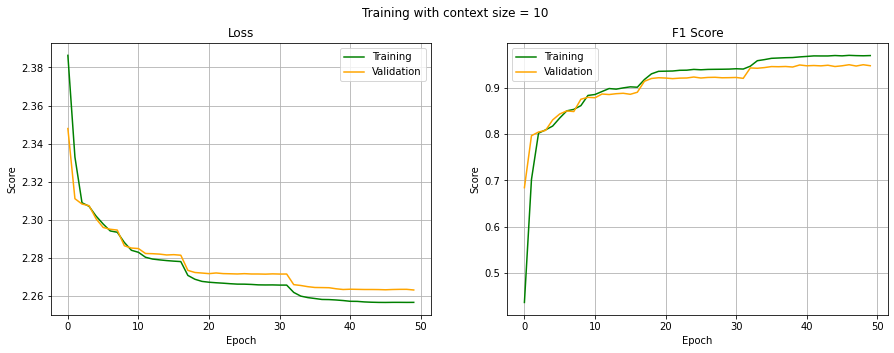

In [22]:
now = datetime.now(pytz.timezone("Asia/Ujung_Pandang"))
path_name = now.strftime("%m-%d-%Y_%H-%M-%S")
root_path = f"../../../logs/classifier/{hyperparams.context_size}_contexts/fold_0{hyperparams.fold}/{path_name}"
os.makedirs(root_path)

def looping_step(train_dataloader, val_dataloader, model, optimizer, criterion, train_metric, val_metric, n_epoch=hyperparams.n_epoch, patience=hyperparams.patience, monitor="loss"):    
    start_time = time()
    
    epoch_training_losses = []
    epoch_training_metric_scores = []
    epoch_val_losses = []
    epoch_val_metric_scores = []
    patience_counter = 0
    
    # Hyperparameters
    with open(f"{root_path}/training_history.txt", "a") as f:
        f.write(f"HYPERPARAMETERS\n")
        f.write(f"{'-' * 80}\n")
        for name, value in vars(hyperparams).items():
            f.write(f"{name}: {value}\n")
        
        f.write("\n\nTRAINING PROGRESS\n")
        f.write(f"{'-' * 80}\n")
    
    # Training Progress
    for epoch in range(1, n_epoch + 1):
        print(f"EPOCH-{epoch}")
        with open(f"{root_path}/training_history.txt", "a") as f:
            f.write(f"EPOCH-{epoch}\n")
            f.write(f"Training Step\n")
            
        # Training Step
        print("Training Step")
        batch_training_losses, batch_training_metric_scores = training_step(train_dataloader, model, optimizer, criterion, train_metric, scheduler=None)
        epoch_training_loss = torch.mean(torch.FloatTensor(batch_training_losses))

        epoch_training_loss = torch.mean(torch.FloatTensor(batch_training_losses))
        epoch_training_losses.append(epoch_training_loss.item())

        epoch_training_metric_score = torch.mean(torch.FloatTensor(batch_training_metric_scores))
        epoch_training_metric_scores.append(epoch_training_metric_score.item())
        
        # Validation Step
        with open(f"{root_path}/training_history.txt", "a") as f:
            f.write(f"\nValidation Step\n")
            
        print("\nValidation Step")
        batch_val_losses, batch_val_metric_scores = validation_step(val_dataloader, model, criterion, val_metric)
        epoch_val_loss = torch.mean(torch.FloatTensor(batch_val_losses))

        epoch_val_loss = torch.mean(torch.FloatTensor(batch_val_losses))
        epoch_val_losses.append(epoch_val_loss.item())

        epoch_val_metric_score = torch.mean(torch.FloatTensor(batch_val_metric_scores))
        epoch_val_metric_scores.append(epoch_val_metric_score.item())
        
        with open(f"{root_path}/training_history.txt", "a") as f:
            if monitor == "loss":
                if epoch == 1:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                elif epoch_training_losses[-1] < epoch_training_losses[-2]:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print("\nYeah üéâüòÑ! Model improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write("\nYeah üéâüòÑ! Model improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                else:
                    patience_counter += 1
                    
                    print("\nHuft üò•! Model not improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    print(f"Patience = {patience_counter}/{patience}‚ùó")
                    
                    f.write("\nHuft üò•! Model not improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                    f.write(f"Patience = {patience_counter}/{patience}‚ùó\n")
            else:
                if epoch == 1:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                elif epoch_training_metric_scores[-1] > epoch_training_metric_scores[-2]:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print("\nYeah üéâüòÑ! Model improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write("\nYeah üéâüòÑ! Model improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                else:
                    patience_counter += 1
                    
                    print("\nHuft üò•! Model not improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    print(f"Patience = {patience_counter}/{patience}‚ùó\n")
                    
                    f.write("\nHuft üò•! Model not improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                    f.write(f"Patience = {patience_counter}/{patience}‚ùó\n")
                    
            print("=" * 80, end="\n\n")
            
            f.write(f"{'=' * 80}\n\n")
            
            if patience_counter == patience:
                print(f"Early stopping, patience = {patience_counter}/{patience}‚ùó\n")
                
                f.write(f"Early stopping, patience = {patience_counter}/{patience}‚ùó\n")
                break
        
        train_metric.reset()
        val_metric.reset()
        
    finish_time = time()
    
    # Training plot 
    fig, (ax_loss, ax_metric_score) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    fig.suptitle(f"Training with context size = {hyperparams.context_size}")

    ax_loss.set_title("Loss")
    ax_loss.set_xlabel("Epoch")
    ax_loss.set_ylabel("Score")
    ax_loss.plot(epoch_training_losses, "green", label="Training")
    ax_loss.plot(epoch_val_losses, "orange", label="Validation")
    ax_loss.legend()
    ax_loss.grid()

    ax_metric_score.set_title("F1 Score")
    ax_metric_score.set_xlabel("Epoch")
    ax_metric_score.set_ylabel("Score")
    ax_metric_score.plot(epoch_training_metric_scores, "green", label="Training")
    ax_metric_score.plot(epoch_val_metric_scores, "orange", label="Validation")
    ax_metric_score.legend()
    ax_metric_score.grid()

    plt.savefig(f"{root_path}/training_plot.jpg", dpi=200)                        
    
    print("TRAINING SUMMARY")
    name_best_training_loss = f"Best {str(criterion).split('(')[0]} training".ljust(34)
    name_best_training_metric = f"Best {str(train_metric).split('(')[0]} validation".ljust(34)
    name_best_validation_loss = f"Best {str(criterion).split('(')[0]} training".ljust(34)
    name_best_validation_metric = f"Best {str(val_metric).split('(')[0]} validation".ljust(34)
    name_training_time = f"Training duration".ljust(34)
    name_training_date = f"Training date".ljust(34)
    
    print(f"{name_best_training_loss}: {best_training_loss:.4f}")
    print(f"{name_best_validation_loss}: {best_val_loss:.4f}")
    print(f"{name_best_training_metric}: {best_training_metric:.4f}")
    print(f"{name_best_validation_metric}: {best_val_metric:.4f}")
    print(f"{name_training_time}: {((finish_time - start_time) / 60):.4f} minutes.")
    print(f"{name_training_date}: {now}")
    
    with open(f"{root_path}/training_history.txt", "a") as f:
        f.write("\nTRAINING SUMMARY\n")
        f.write(f"{'-' * 80}\n")
        f.write(f"{name_best_training_loss}: {best_training_loss:.4f}\n")
        f.write(f"{name_best_validation_loss}: {best_val_loss:.4f}\n")
        f.write(f"{name_best_training_metric}: {best_training_metric:.4f}\n")
        f.write(f"{name_best_validation_metric}: {best_val_metric:.4f}\n")
        f.write(f"{name_training_time}: {((finish_time - start_time) / 60):.4f} minutes.\n")
        f.write(f"{name_training_date}: {now}\n")
    
    # Save epoch losses, epoch metric scores, model, state dict, and oov embedding dict
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "loss": epoch_training_losses
    }).to_csv(f"{root_path}/training_losses.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "f1_score": epoch_training_metric_scores
    }).to_csv(f"{root_path}/training_metric_scores.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "loss": epoch_val_losses
    }).to_csv(f"{root_path}/val_losses.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "f1_score": epoch_val_metric_scores
    }).to_csv(f"{root_path}/val_metric_scores.csv", index=False)    
    
    filename_model_params = f"{root_path}/model_params.pth"
    torch.save(best_state_dict, filename_model_params)
    
    return epoch_training_losses, epoch_training_metric_scores, epoch_val_losses, epoch_val_metric_scores

epoch_training_losses, epoch_training_metric_scores, epoch_val_losses, epoch_val_metric_scores = looping_step(train_dataloader, val_dataloader, model, optimizer, criterion, train_metric, val_metric)

## End Training

# Evaluation

In [23]:
def evaluation(dataloader, model, criterion, metric):
    model.eval()
    
    with torch.inference_mode():
        for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
            # Forward Propagation
            feature = rearrange(feature, "n s -> s n")
            actual_label = rearrange(actual_label, "n s -> s n")
            embedding = word_embeddings(feature)

            prob = model(
                embedding.to(hyperparams.device),
                actual_label.to(hyperparams.device)
            )

            prob = prob.reshape(-1, prob.shape[-1])
            actual_label = actual_label.reshape(-1)
            pred = rearrange(prob.argmax(dim=1).reshape(feature.shape[0], len(dataloader.dataset)), "s n -> n s")

            loss = criterion(prob, actual_label.to(hyperparams.device))
            metric_score = metric(prob.argmax(dim=1), actual_label.to(hyperparams.device))
            metric_score = metric.compute()

    return loss, metric_score, pred

train_dataloader = DataLoader(train_dataset, batch_size=len(train_dataset))
val_dataloader = DataLoader(val_dataset, batch_size=len(val_dataset))
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset))

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
train_loss, train_f1_score, train_pred_label = evaluation(train_dataloader, model, criterion, metric)

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
val_loss, val_f1_score, val_pred_label = evaluation(val_dataloader, model, criterion, metric)

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
test_loss, test_f1_score, test_pred_label = evaluation(test_dataloader, model, criterion, metric)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [24]:
train_f1_score, val_f1_score, test_f1_score

(tensor(0.9711, device='cuda:0'),
 tensor(0.9496, device='cuda:0'),
 tensor(0.9455, device='cuda:0'))

In [25]:
train_f1_score, val_f1_score, test_f1_score

(tensor(0.9711, device='cuda:0'),
 tensor(0.9496, device='cuda:0'),
 tensor(0.9455, device='cuda:0'))

## Heatmap

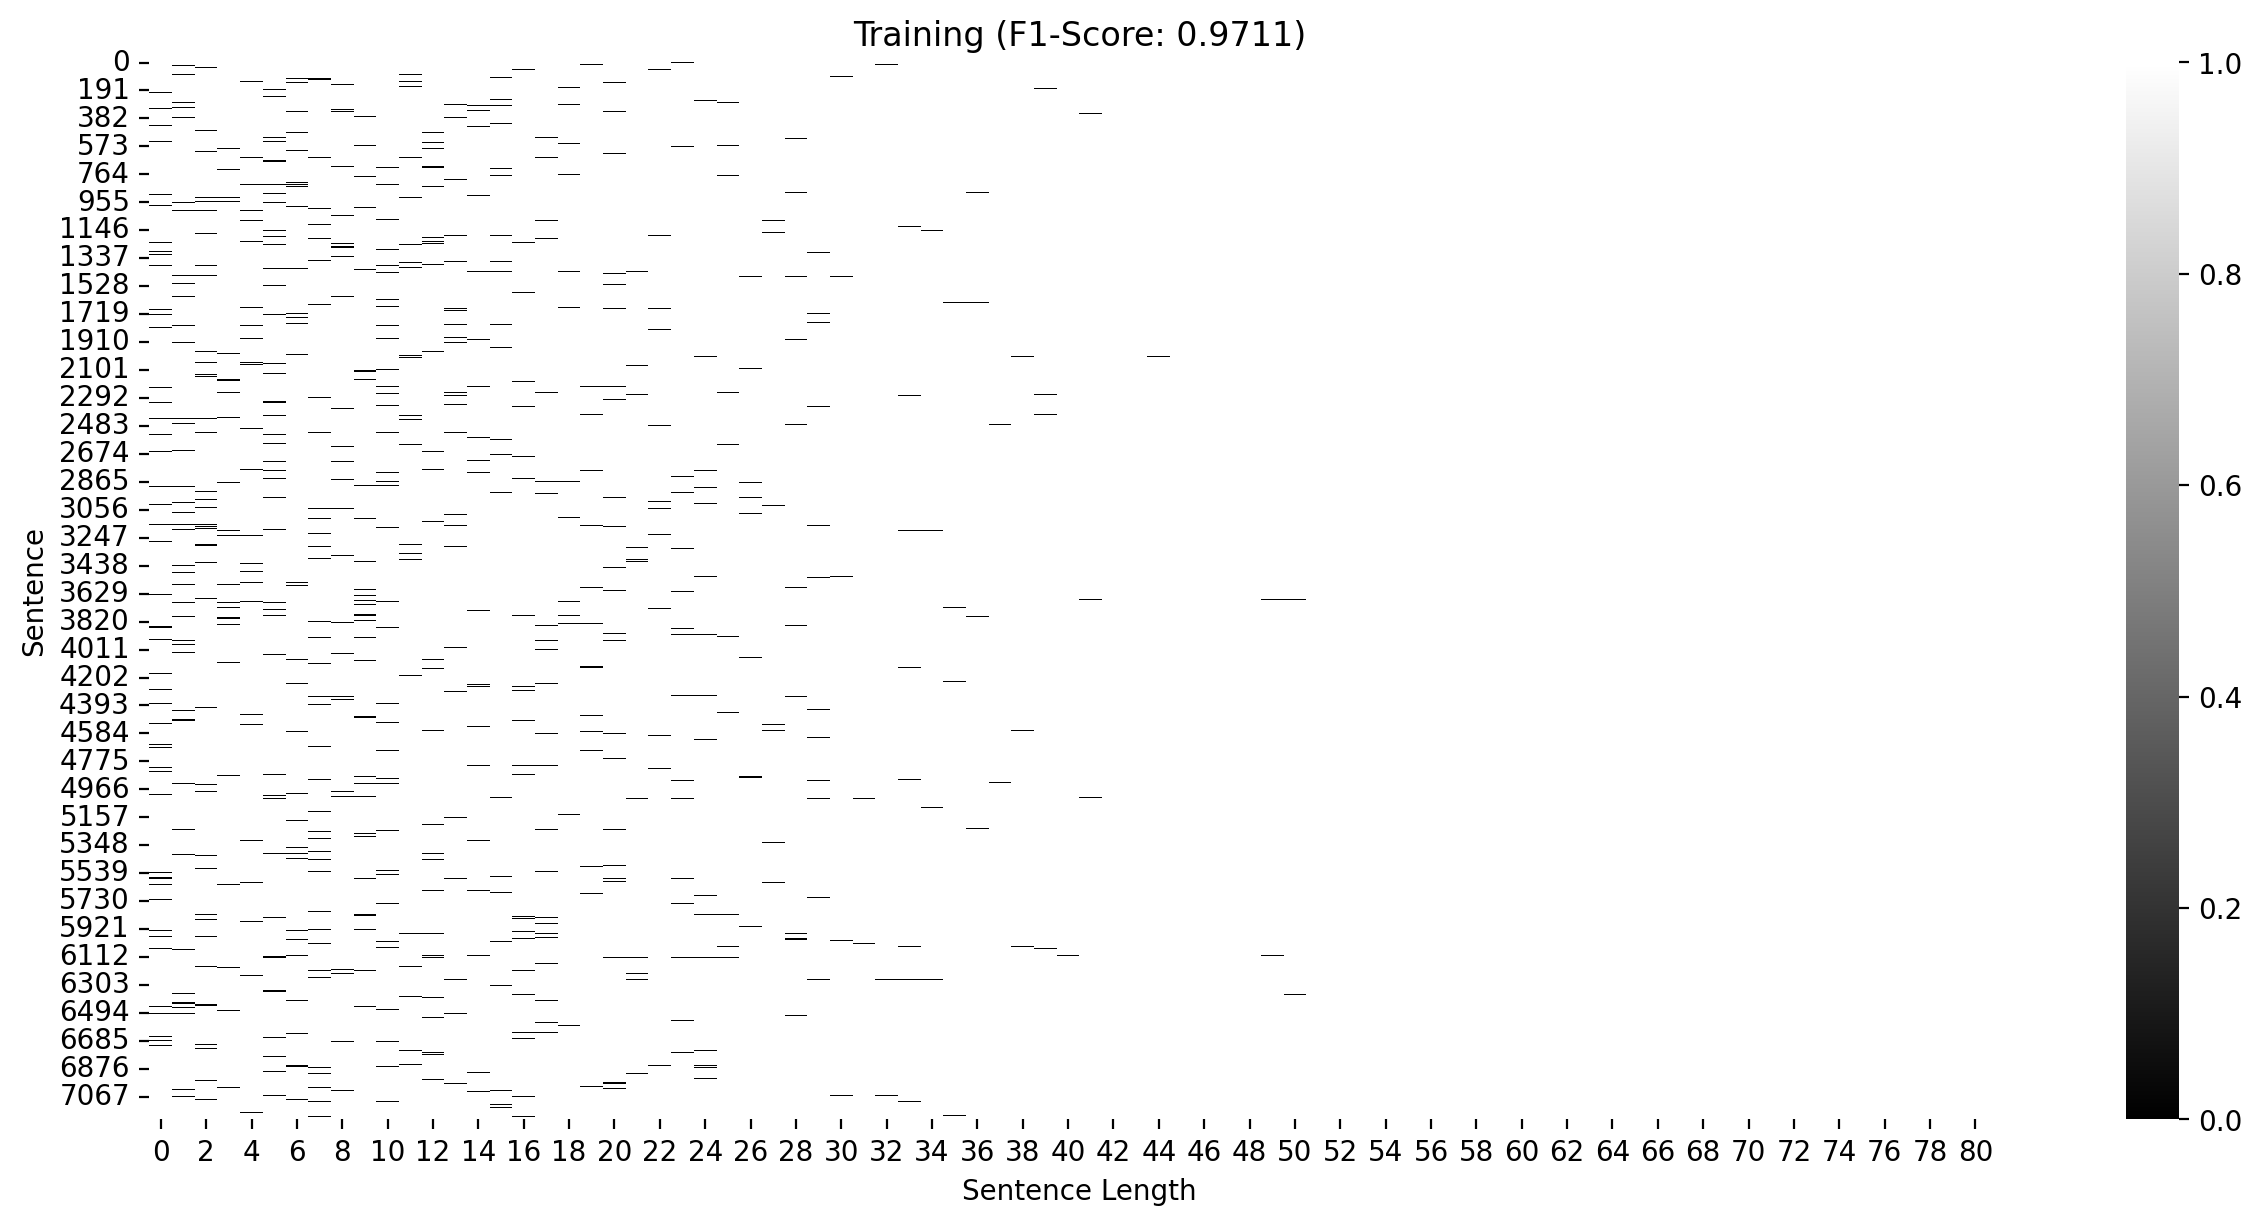

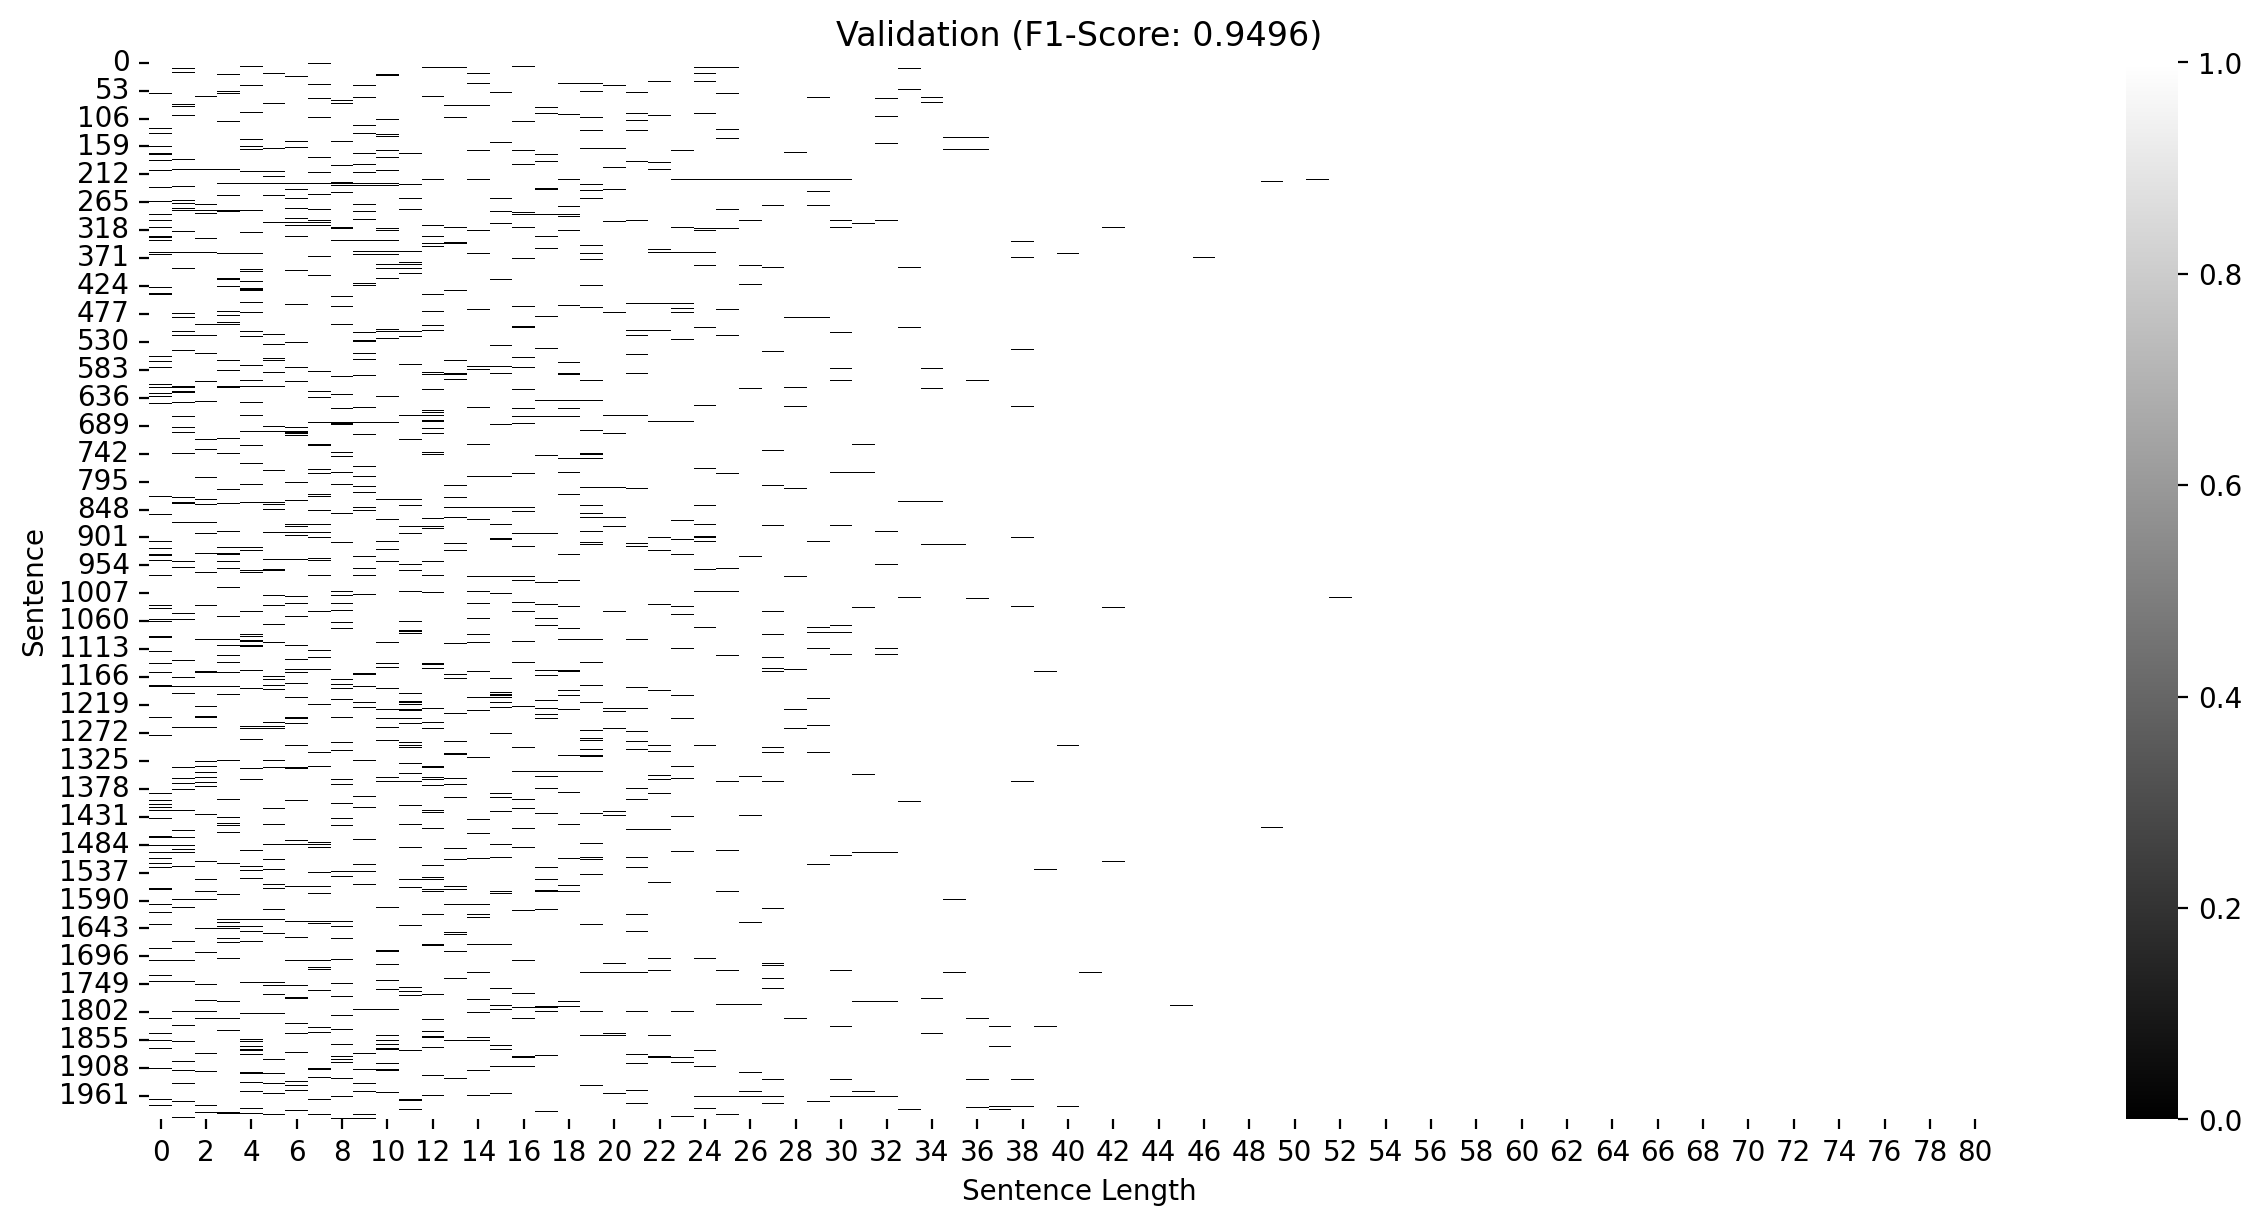

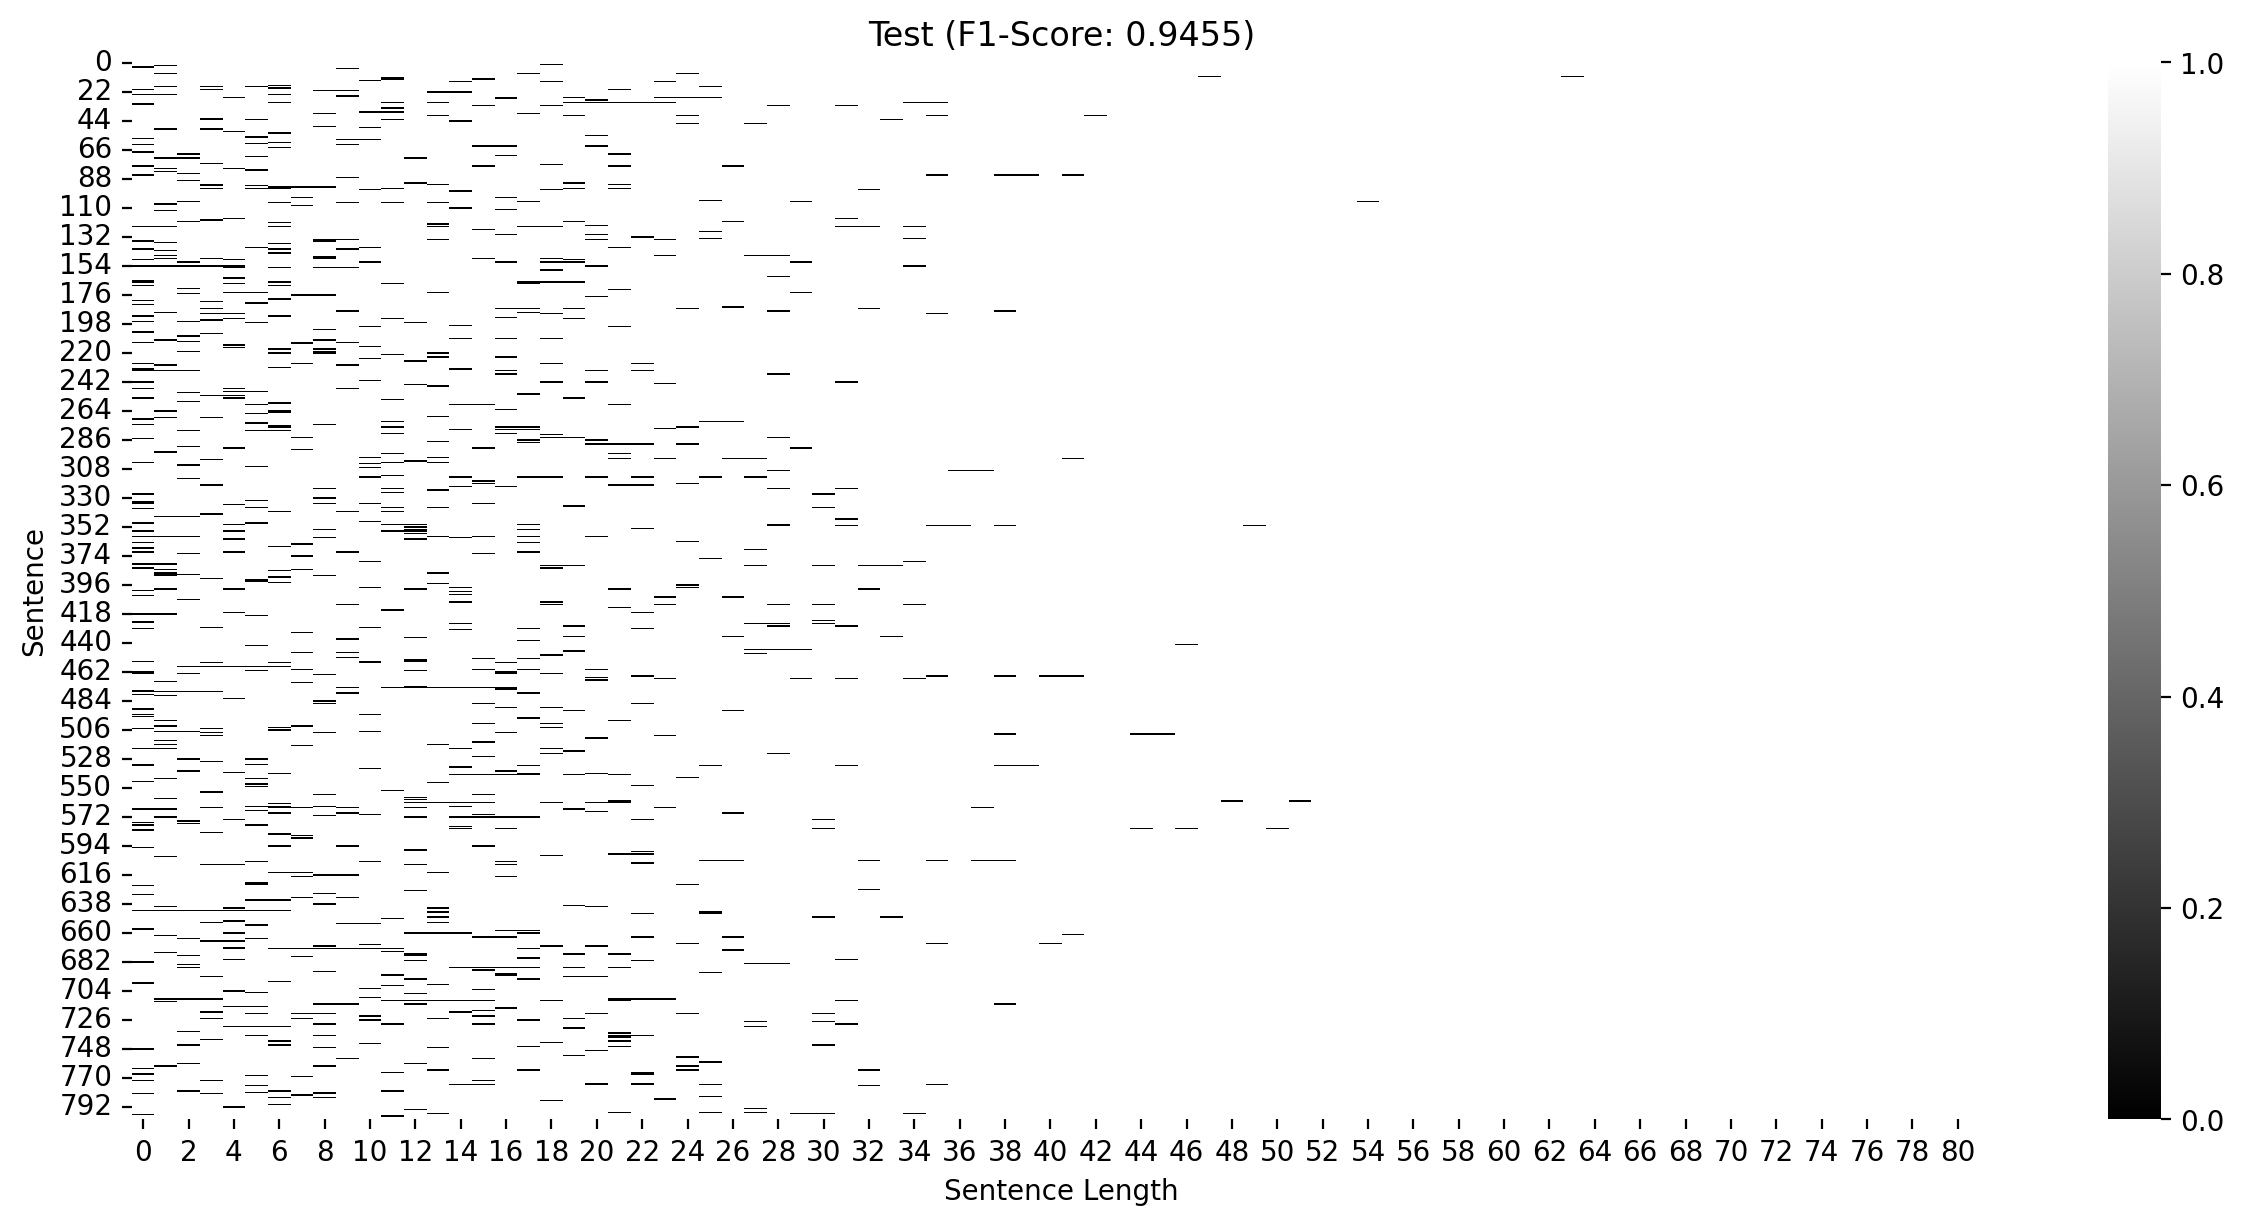

In [26]:
import seaborn as sns

def viz_evaluation(pred_label, actual_label, title):
    plt.figure(figsize=(15, 7), dpi=200)
    sns.heatmap(pred_label.detach().cpu() == actual_label, cbar=True, cmap="binary_r")
    plt.xlabel("Sentence Length")
    plt.ylabel("Sentence")
    plt.title(title)
    plt.savefig(f"{root_path}/heatmap_{title.lower()}.jpg", dpi=200)
    plt.show()

train_actual_label = train_dataloader.dataset.tensors[1]
val_actual_label = val_dataloader.dataset.tensors[1]
test_actual_label = test_dataloader.dataset.tensors[1]

viz_evaluation(train_pred_label, train_actual_label, f"Training (F1-Score: {(train_f1_score):.4f})")
viz_evaluation(val_pred_label, val_actual_label, f"Validation (F1-Score: {(val_f1_score):.4f})")
viz_evaluation(test_pred_label, test_actual_label, f"Test (F1-Score: {(test_f1_score):.4f})")

## Confusion Matrix

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: 120 NaN values found in confusion matrix have been replaced with zeros.
  warnings.warn(*args, **kwargs)
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: 144 NaN values found in confusion matrix have been replaced with zeros.
  warnings.warn(*args, **kwargs)


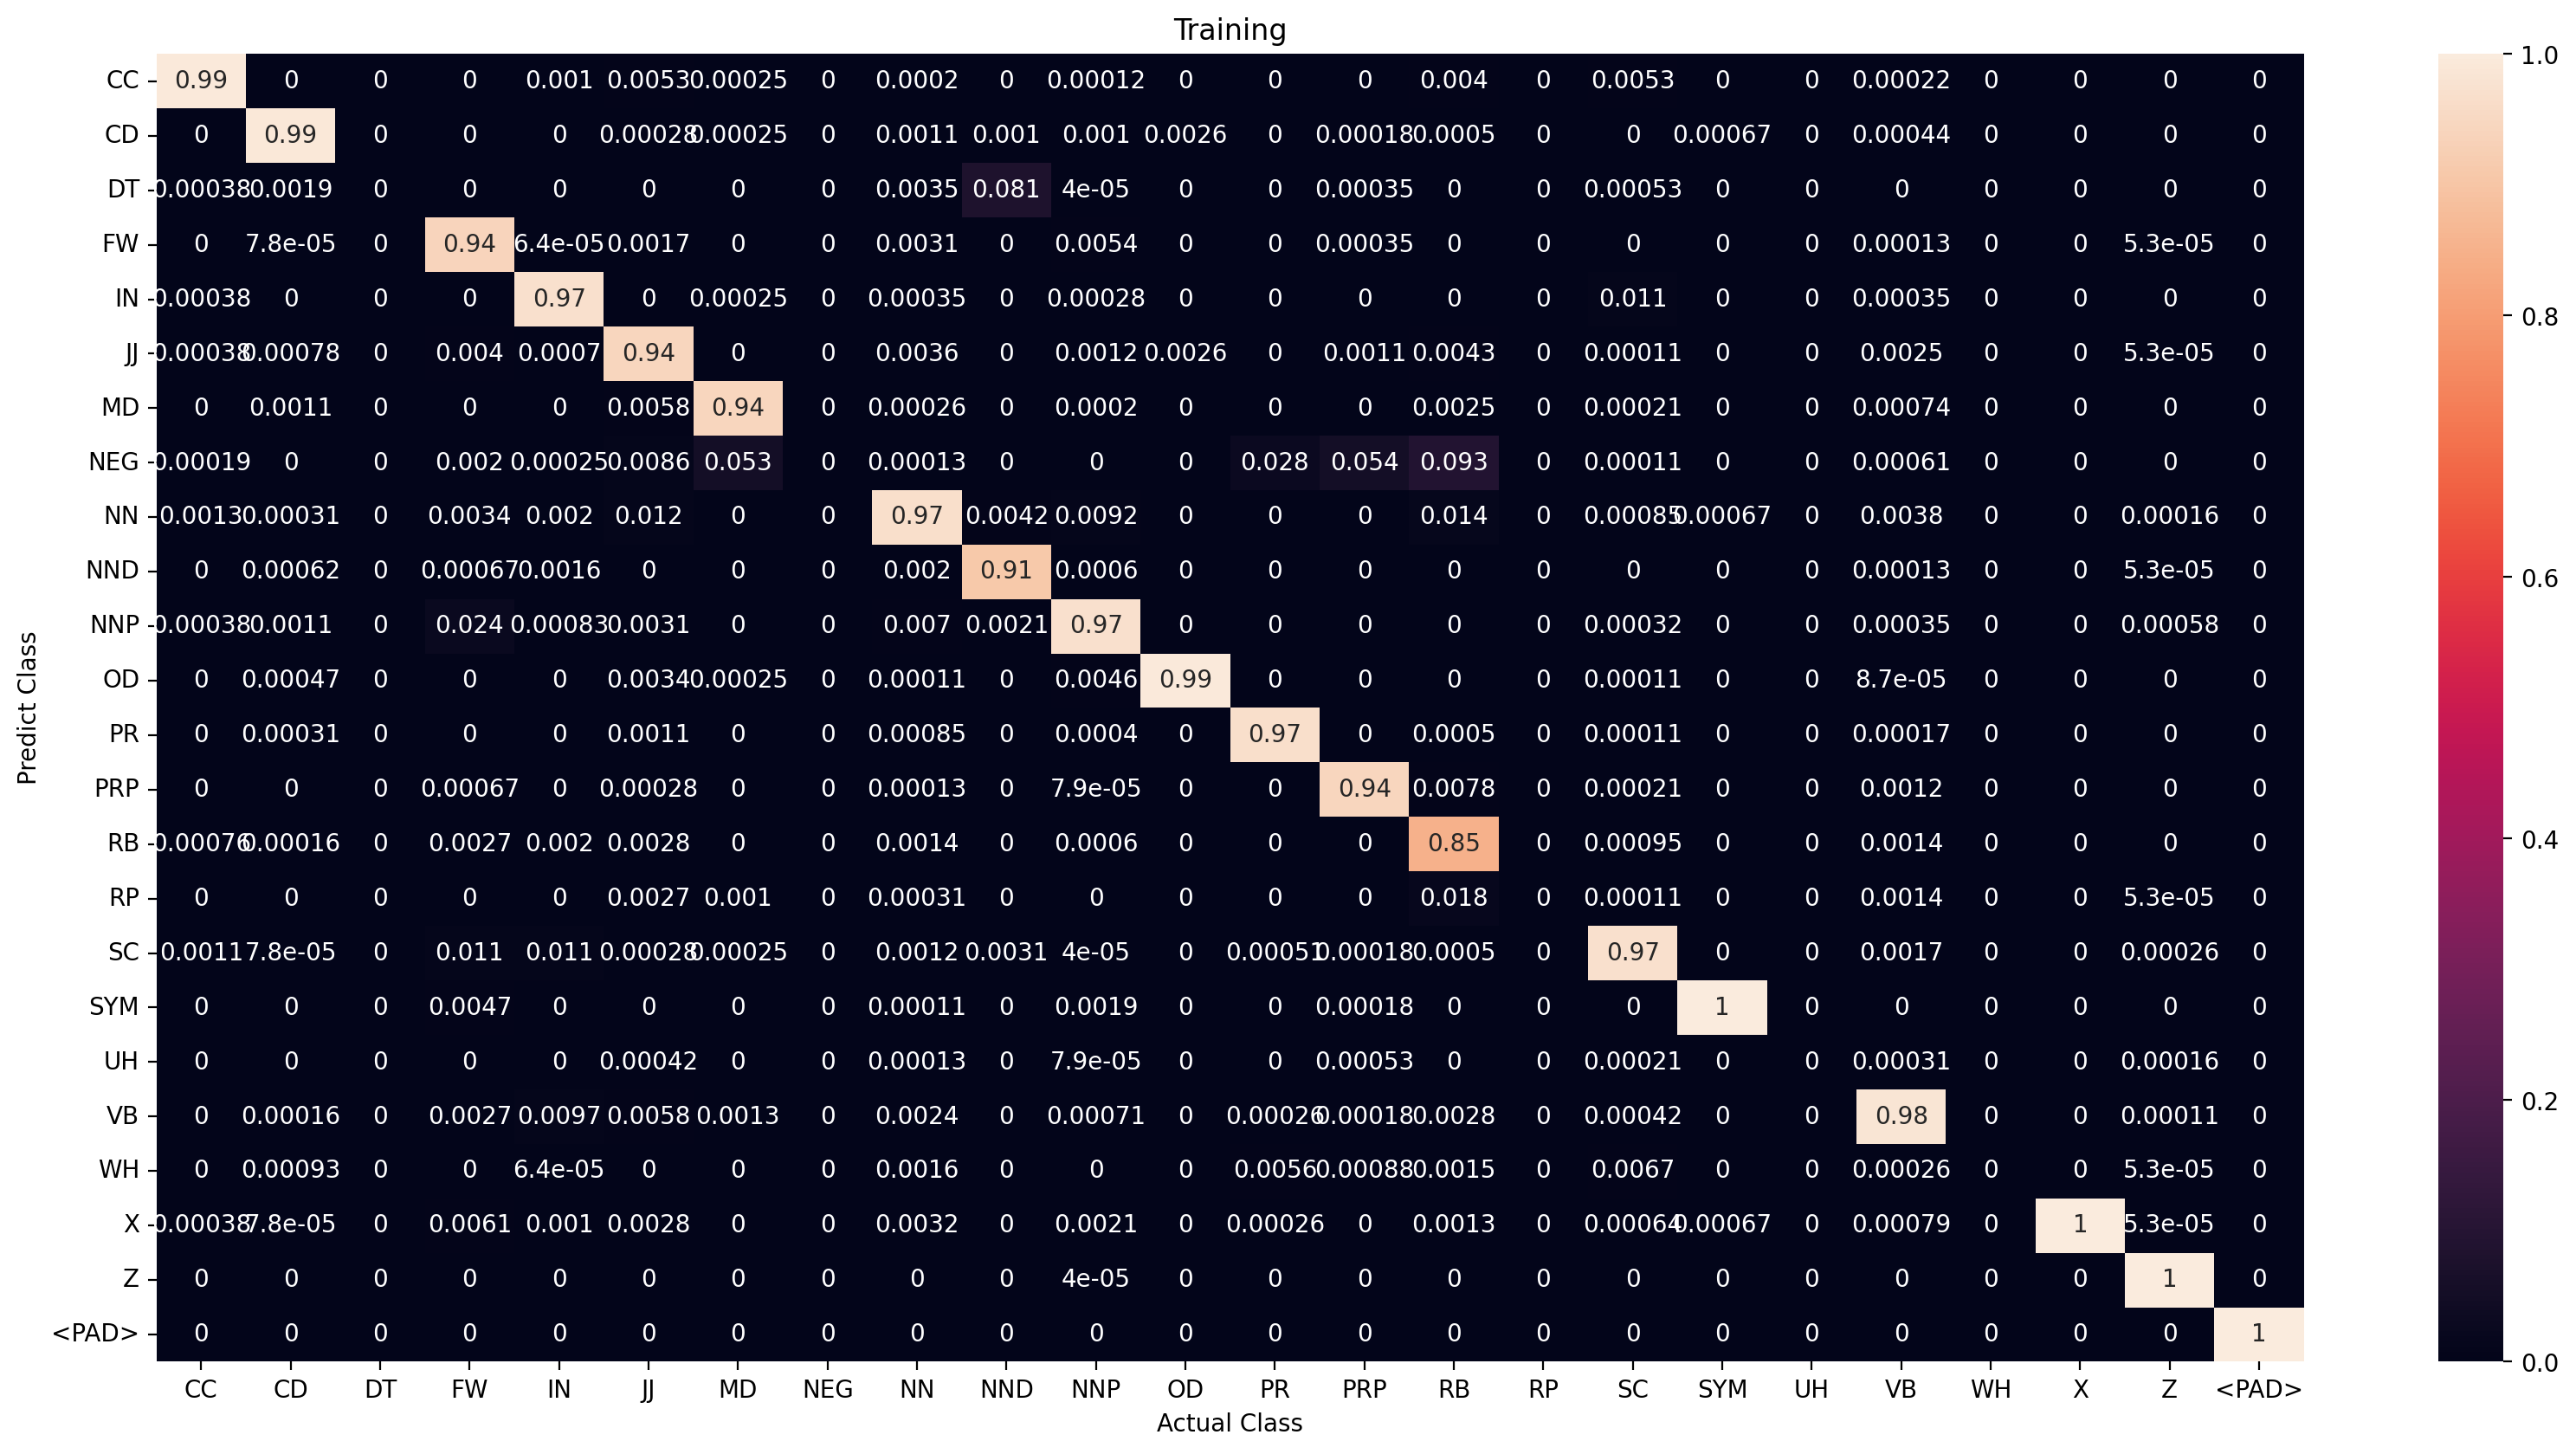

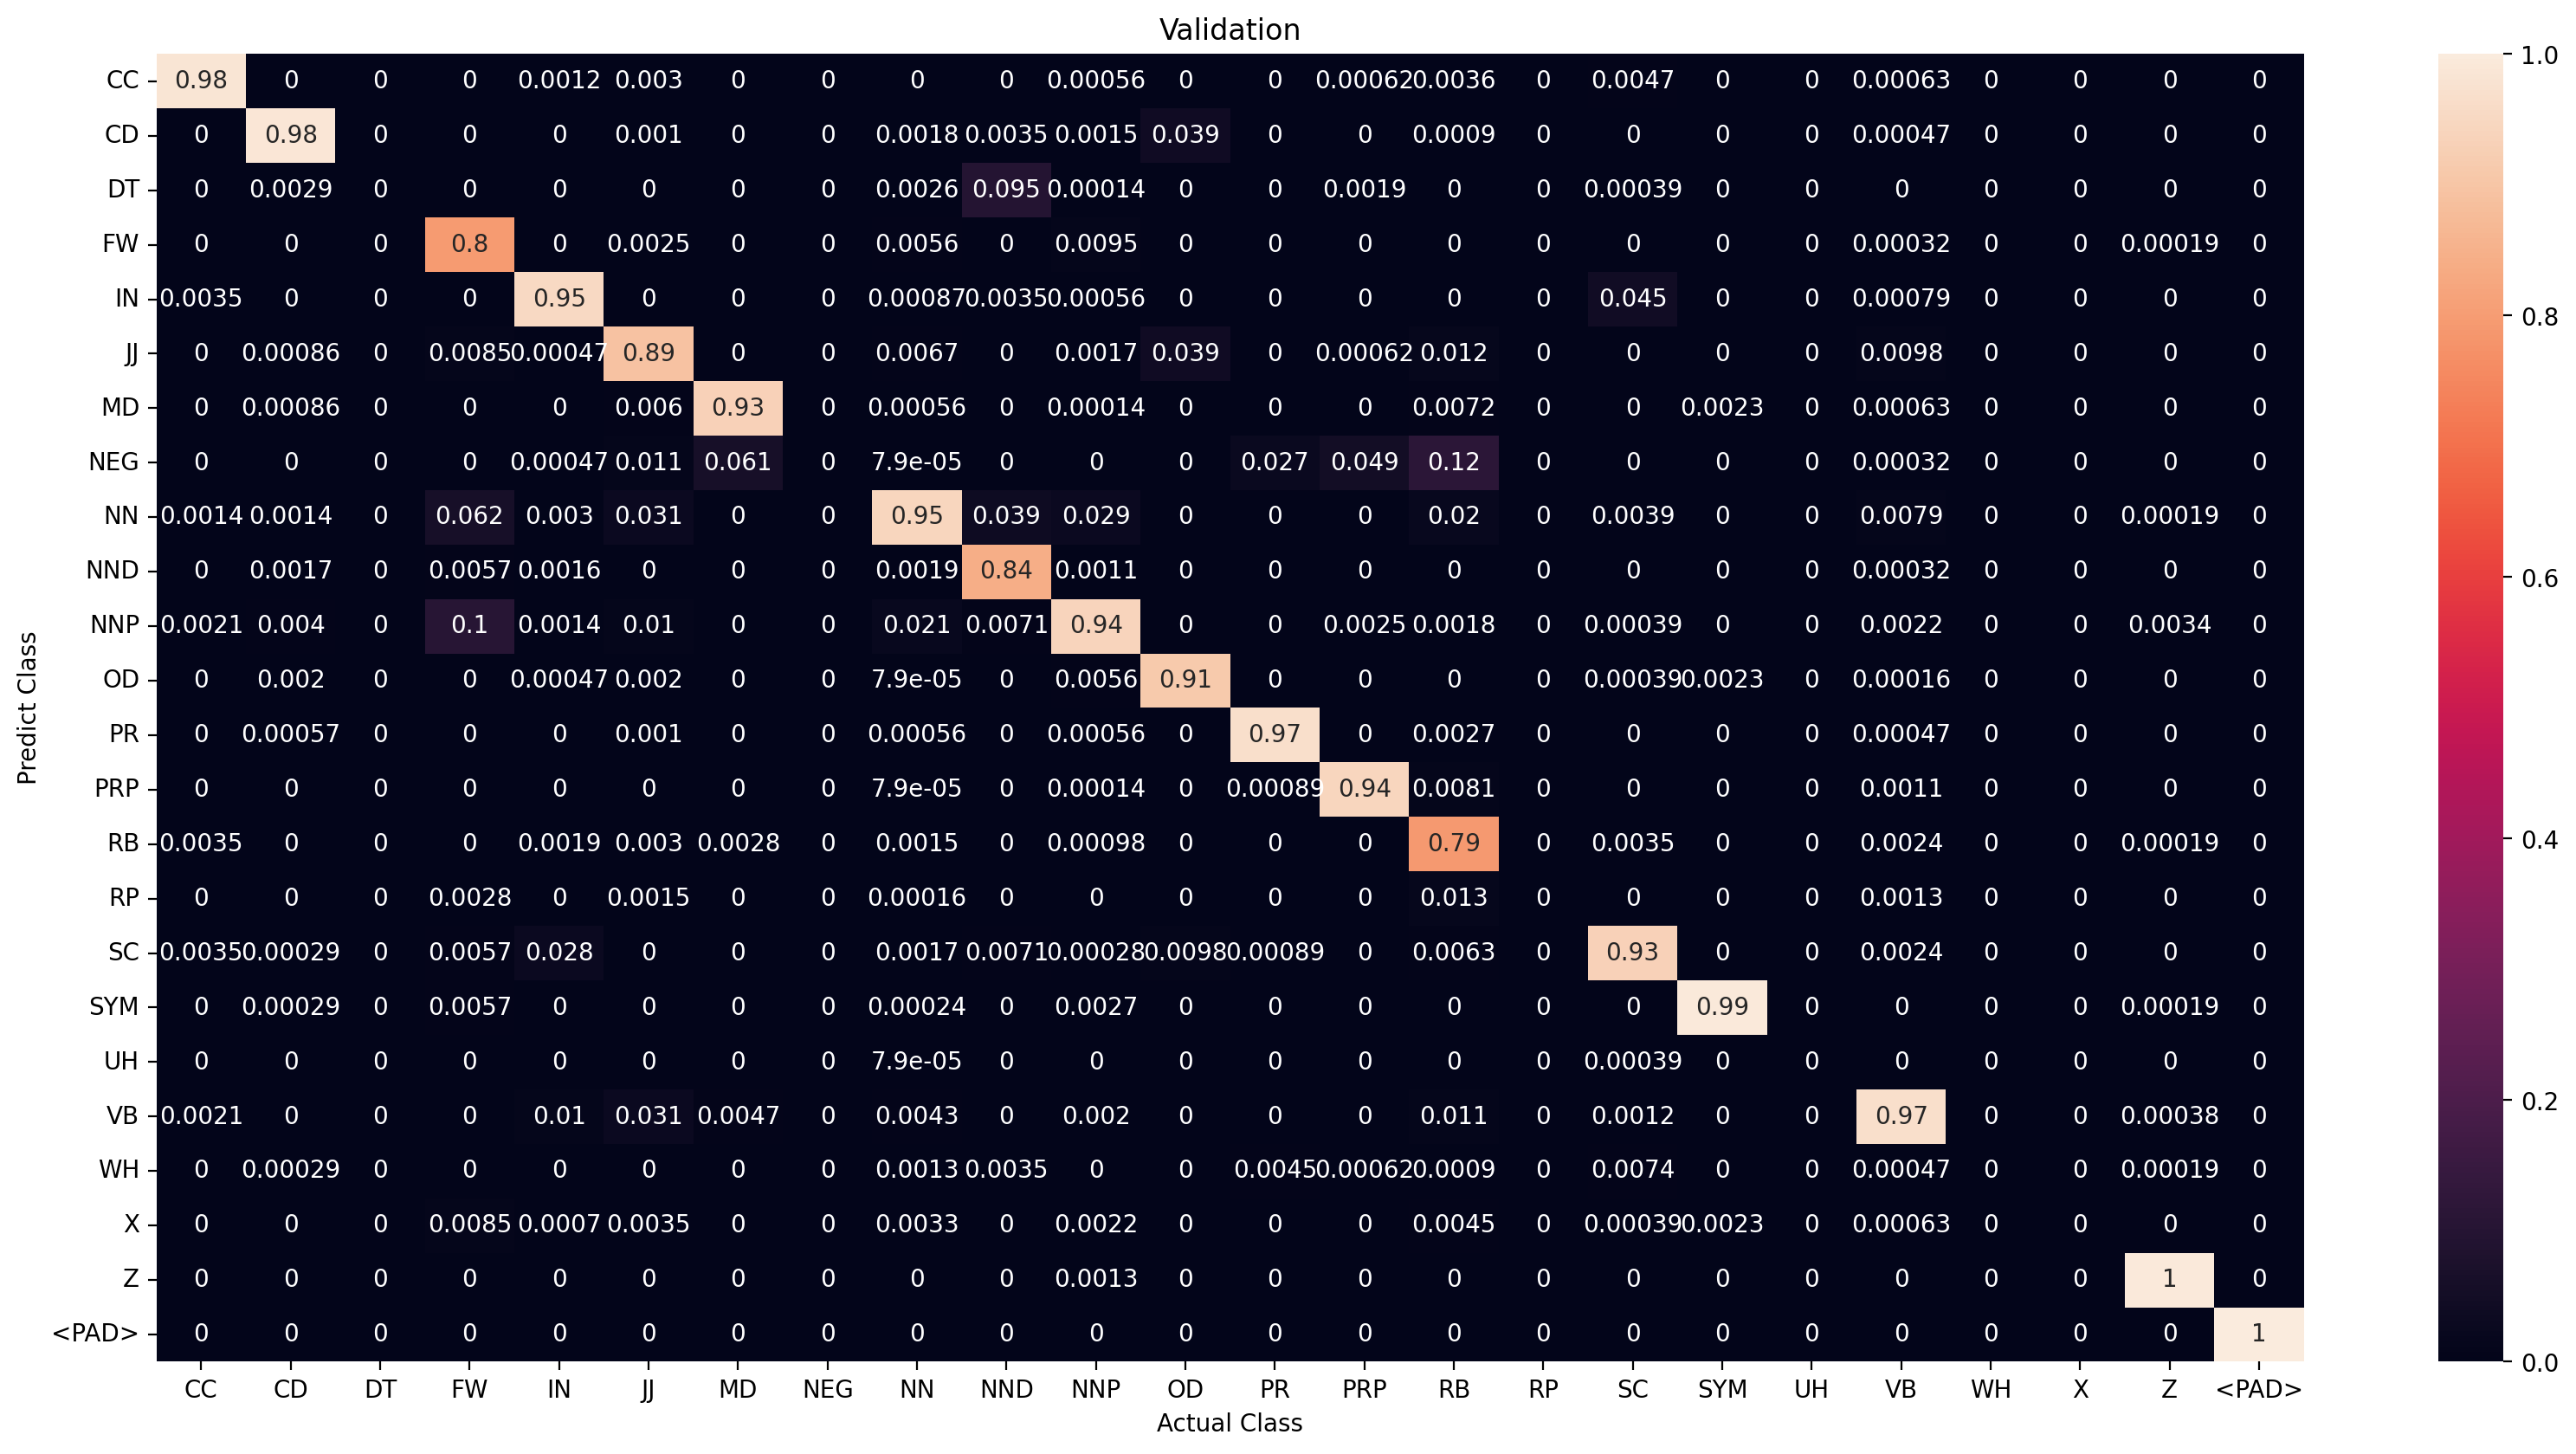

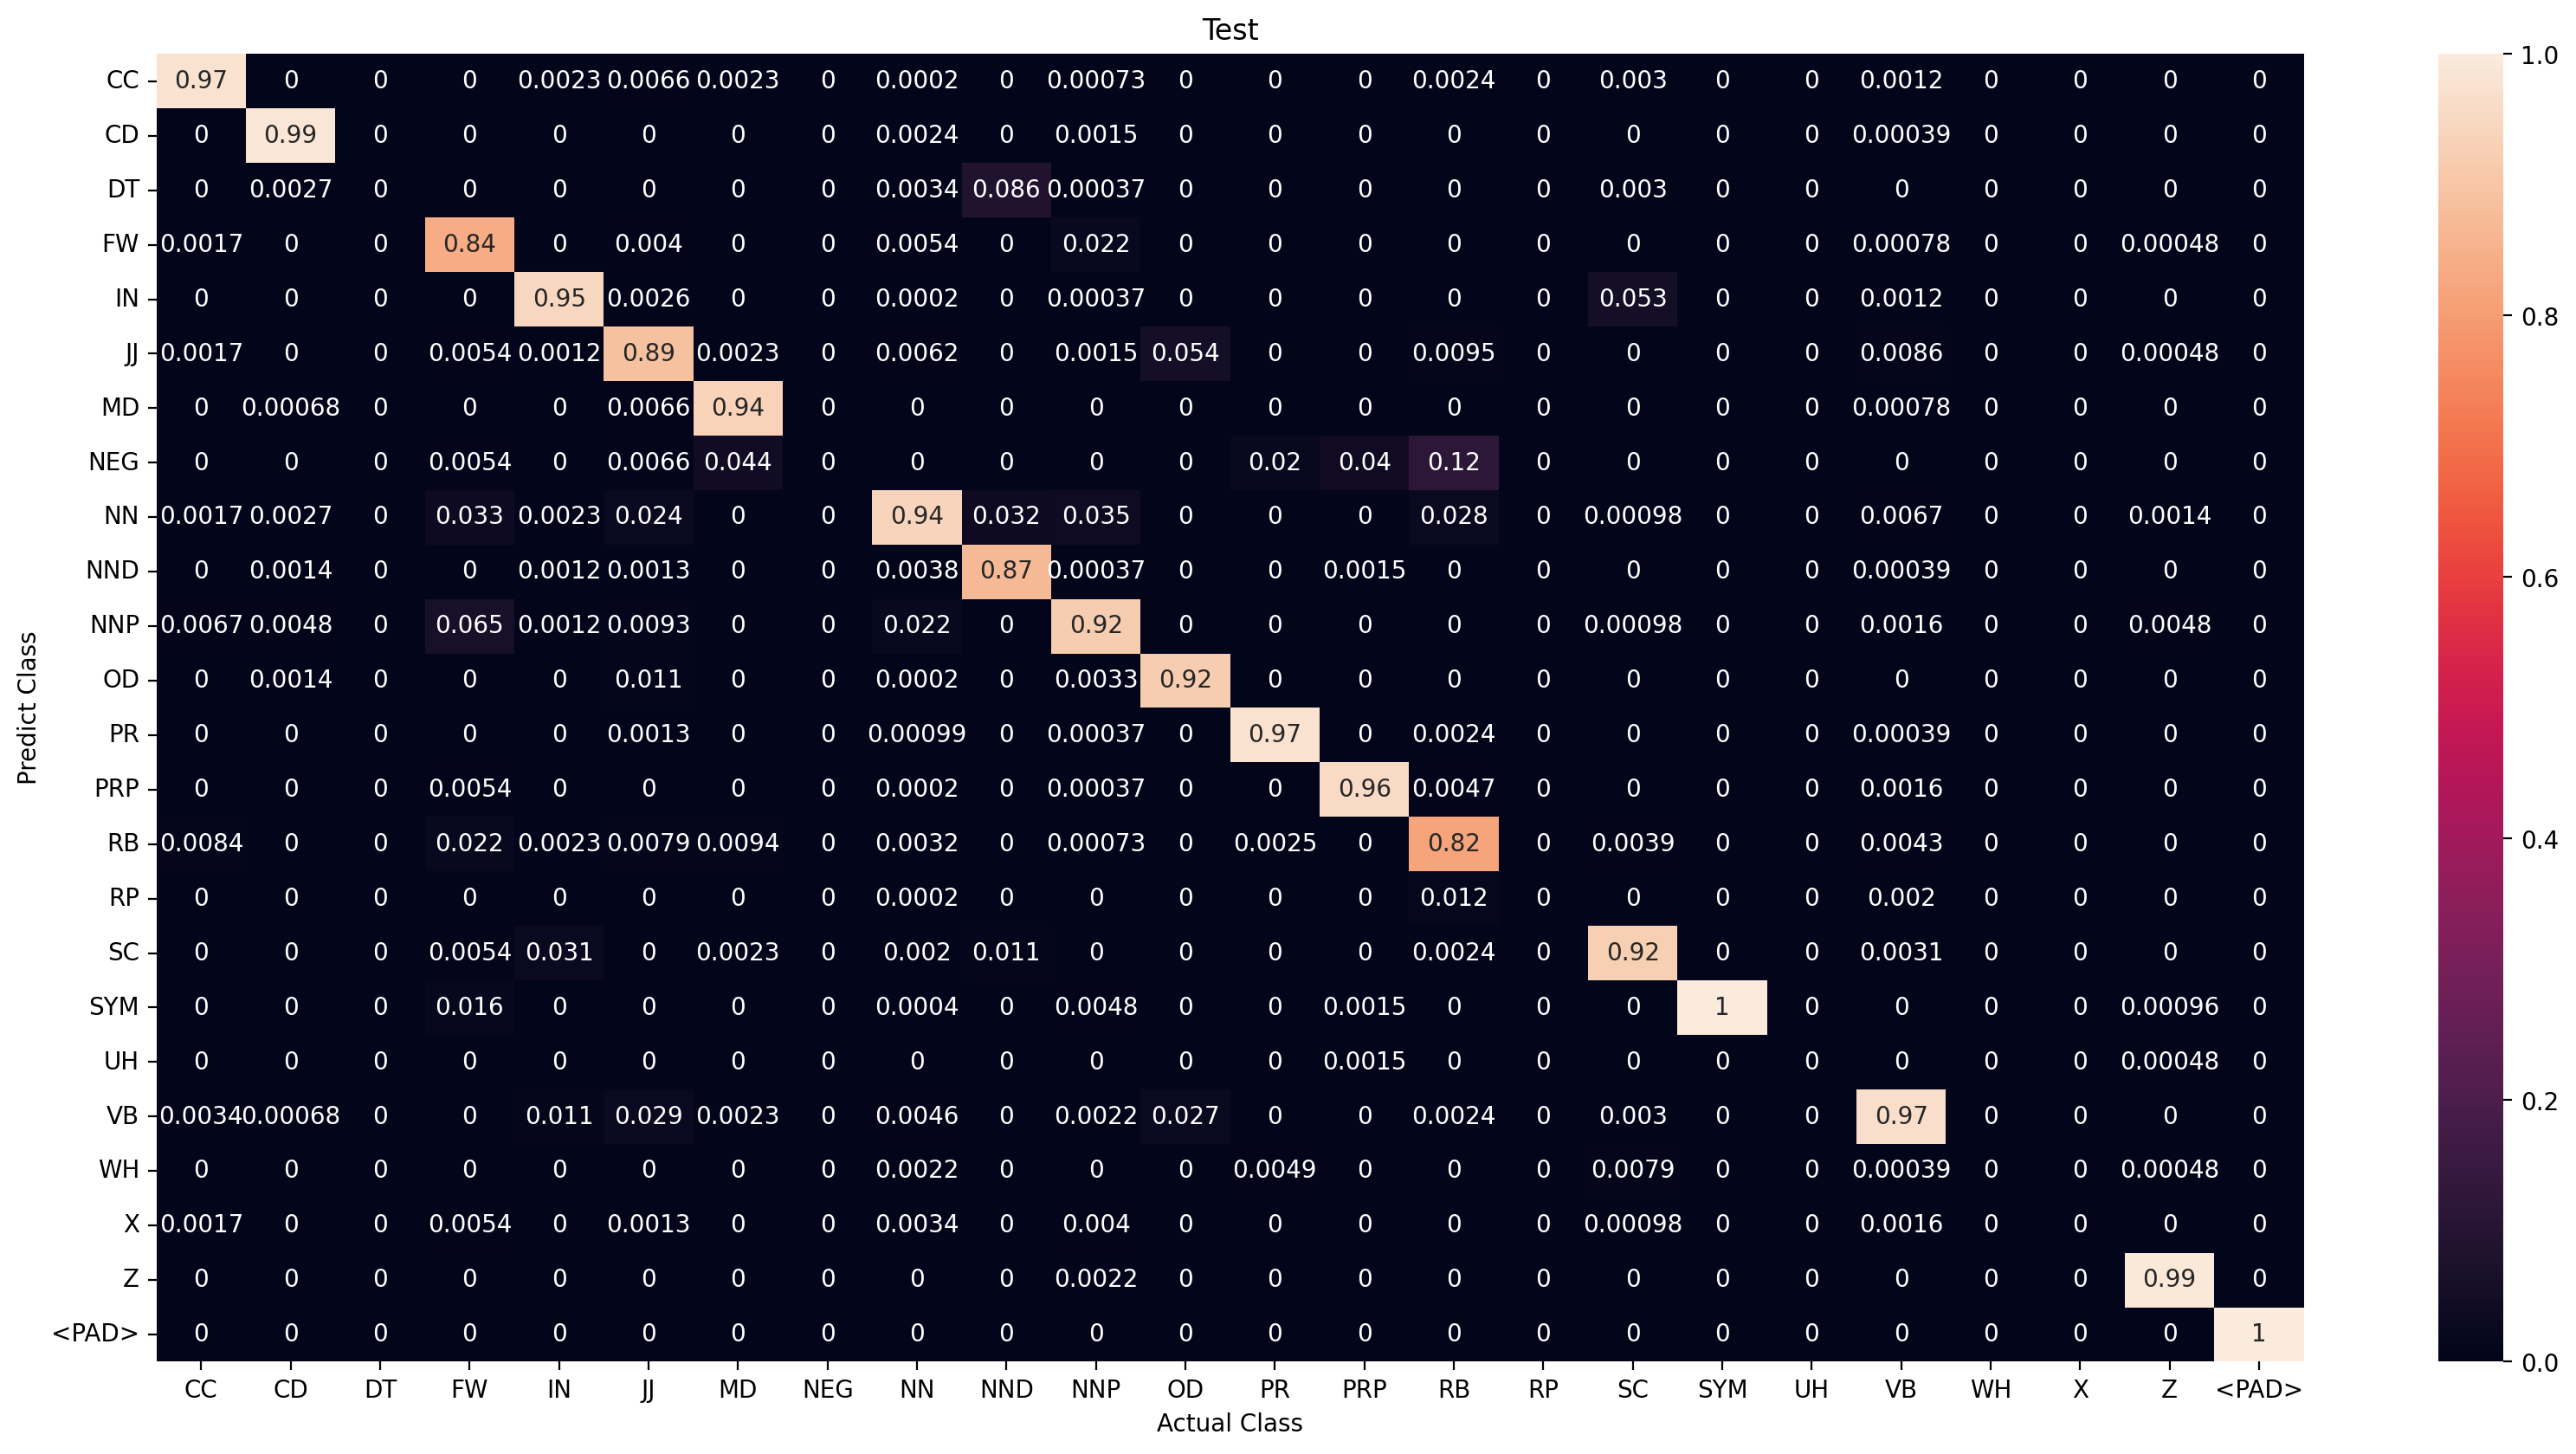

In [27]:
def confusion_matrix(pred_class, actual_class, title, normalize=None):
    conf_mat = MulticlassConfusionMatrix(num_classes=24, normalize=normalize)
    plt.figure(figsize=(20, 10), dpi=200)
    sns.heatmap(conf_mat(pred_class.detach().cpu(), actual_class), annot=True, fmt=".2g", xticklabels=list(label_to_idx.keys()), yticklabels=list(label_to_idx.keys()));
    plt.yticks(rotation=0)
    plt.title(title)
    plt.xlabel("Actual Class")
    plt.ylabel("Predict Class")
    plt.savefig(f"{root_path}/conf_matrix_{title.lower()}.jpg", dpi=200)

confusion_matrix(train_pred_label, train_actual_label, "Training", "pred")
confusion_matrix(val_pred_label,val_actual_label, "Validation", "pred")
confusion_matrix(test_pred_label, test_actual_label, "Test", "pred")

## Prediction Table

In [28]:
def number_wrong_pred_each_class(pred_class, actual_class):
    classes, count_class = actual_class.flatten().unique(return_counts=True)
    conf_mat = MulticlassConfusionMatrix(num_classes=24, normalize="none")
    correct_pred_count_class = conf_mat(pred_class.detach().cpu(), actual_class).diag()
    
    correct_pred = {idx_to_label[label.item()]: count.item() for label, count in zip(classes, (correct_pred_count_class))}
    wrong_pred = {idx_to_label[label.item()]: count.item() for label, count in zip(classes, (count_class - correct_pred_count_class))}
    
    return correct_pred, wrong_pred

correct_pred, wrong_pred = number_wrong_pred_each_class(train_pred_label, train_actual_label)
print(f"| {'Number class'.ljust(14)} | {'Correct prediction'.ljust(12)} | {'Wrong prediction'.ljust(12)} |")
for (label_correct_pred, count_correct_pred), (label_wrong_pred, count_wrong_pred) in zip(correct_pred.items(), wrong_pred.items()):
    print(f"| {str(label_correct_pred).ljust(6)}: {str(count_correct_pred + count_wrong_pred).ljust(7)}| {label_correct_pred.ljust(6)}: {str(count_correct_pred).ljust(10)} | {label_wrong_pred.ljust(6)}: {str(count_wrong_pred).ljust(8)} |")

| Number class   | Correct prediction | Wrong prediction |
| CC    : 5391   | CC    : 5253       | CC    : 138      |
| CD    : 12882  | CD    : 12787      | CD    : 95       |
| DT    : 273    | DT    : 0          | DT    : 273      |
| FW    : 1690   | FW    : 1393       | FW    : 297      |
| IN    : 15403  | IN    : 15269      | IN    : 134      |
| JJ    : 7018   | JJ    : 6710       | JJ    : 308      |
| MD    : 3810   | MD    : 3709       | MD    : 101      |
| NEG   : 1082   | NEG   : 0          | NEG   : 1082     |
| NN    : 44728  | NN    : 44208      | NN    : 520      |
| NND   : 1019   | NND   : 874        | NND   : 145      |
| NNP   : 24885  | NNP   : 24454      | NNP   : 431      |
| OD    : 534    | OD    : 378        | OD    : 156      |
| PR    : 3842   | PR    : 3774       | PR    : 68       |
| PRP   : 5405   | PRP   : 5334       | PRP   : 71       |
| RB    : 3553   | RB    : 3374       | RB    : 179      |
| RP    : 144    | RP    : 0          | RP    : 144     

In [29]:
train_actual_label[308], train_pred_label[308]

(tensor([ 8, 19, 22, 10, 22, 19, 10,  6, 19,  4,  1,  8, 16, 19,  8, 19,  0,  8,
          5, 16, 19, 19,  8,  8, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23]),
 tensor([ 8, 19, 22, 10, 22, 19, 10,  6, 19,  4,  1,  8, 16, 19,  8, 19,  0,  8,
          5, 16, 19, 19,  8,  8, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23], device='cuda:0'))

In [30]:
train_actual_label[308] == train_pred_label[308].detach().cpu()

tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True])

## OOV prediction is correct 

In [31]:
def oov_flag_token(sentences, max_seq_len=hyperparams.max_seq_len):
    sent_copy = deepcopy(sentences)
    sent = []
    oov_flag = []
    
    for sentence in tqdm(sent_copy):
        for token in sentence:
            sent.append(token[2])
        
        for _ in range(max_seq_len- len(sentence)):
            sent.append(False)
        
        oov_flag.append(sent)
        sent = []
        
    return np.array(oov_flag)

train_oov_flag = oov_flag_token(train_sentences, max_seq_len=hyperparams.max_seq_len)
val_oov_flag = oov_flag_token(val_sentences, max_seq_len=hyperparams.max_seq_len)
test_oov_flag = oov_flag_token(test_sentences, max_seq_len=hyperparams.max_seq_len)

def pencentage_oov_pred_correct(pred_oov_flag, oov_flag_tensor):
    oov_correct_counter = 0
    oov_wrong_counter = 0

    for pred, oov_label in tqdm(zip(pred_oov_flag, oov_flag_tensor)):
        if pred == True and oov_label == True:
            oov_correct_counter += 1
        elif pred == False and oov_label == True:
            oov_wrong_counter += 1
        else:
            continue
            
    return oov_correct_counter, oov_wrong_counter

train_pred_oov_flag = (train_actual_label == train_pred_label.detach().cpu()).flatten()
val_pred_oov_flag = (val_actual_label == val_pred_label.detach().cpu()).flatten()
test_pred_oov_flag = (test_actual_label == test_pred_label.detach().cpu()).flatten()
train_oov_flag_tensor = torch.tensor(train_oov_flag).flatten()
val_oov_flag_tensor = torch.tensor(val_oov_flag).flatten()
test_oov_flag_tensor = torch.tensor(test_oov_flag).flatten()

train_oov_correct_counter, train_oov_wrong_counter = pencentage_oov_pred_correct(train_pred_oov_flag, train_oov_flag_tensor)
val_oov_correct_counter, val_oov_wrong_counter = pencentage_oov_pred_correct(val_pred_oov_flag, val_oov_flag_tensor)
test_oov_correct_counter, test_oov_wrong_counter = pencentage_oov_pred_correct(test_pred_oov_flag, test_oov_flag_tensor)

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [32]:
def print_percentage_pred_oov(title, oov_correct_counter, oov_wrong_counter):
    print(f"{title}")
    print(f"Number OOV token            : {oov_correct_counter + oov_wrong_counter}")
    print(f"Correct prediction          : {oov_correct_counter}")
    print(f"Wrong prediction            : {oov_wrong_counter}")
    print(f"Percentage correct oov pred : {oov_correct_counter / (oov_correct_counter + oov_wrong_counter) * 100}\n")
    
    with open(f"{root_path}/oov_summary.txt", "a") as f:
        f.write(f"{title}\n")
        f.write(f"Number OOV token            : {oov_correct_counter + oov_wrong_counter}\n")
        f.write(f"Correct prediction          : {oov_correct_counter}\n")
        f.write(f"Wrong prediction            : {oov_wrong_counter}\n")
        f.write(f"Percentage correct oov pred : {oov_correct_counter / (oov_correct_counter + oov_wrong_counter) * 100}\n\n")

In [33]:
print_percentage_pred_oov("Training", train_oov_correct_counter, train_oov_wrong_counter)
print_percentage_pred_oov("Validation", val_oov_correct_counter, val_oov_wrong_counter)
print_percentage_pred_oov("Test", test_oov_correct_counter, test_oov_wrong_counter)

Training
Number OOV token            : 11808
Correct prediction          : 10975
Wrong prediction            : 833
Percentage correct oov pred : 92.94546070460704

Validation
Number OOV token            : 3395
Correct prediction          : 3003
Wrong prediction            : 392
Percentage correct oov pred : 88.45360824742268

Test
Number OOV token            : 1359
Correct prediction          : 1187
Wrong prediction            : 172
Percentage correct oov pred : 87.34363502575422



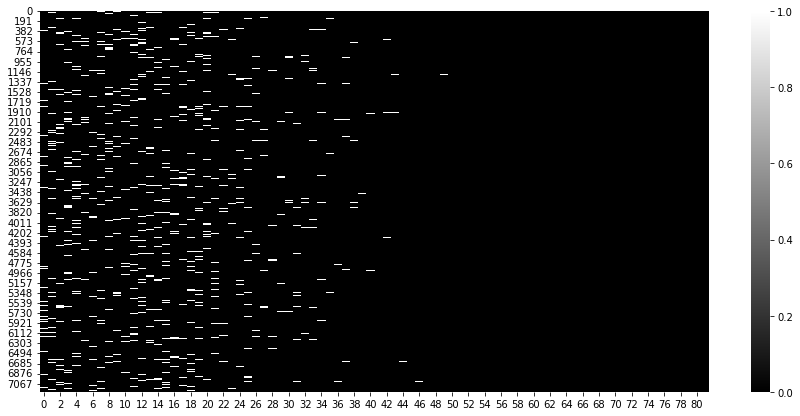

In [34]:
plt.figure(figsize=(15, 7))
sns.heatmap(train_oov_flag, cmap=plt.cm.binary_r);

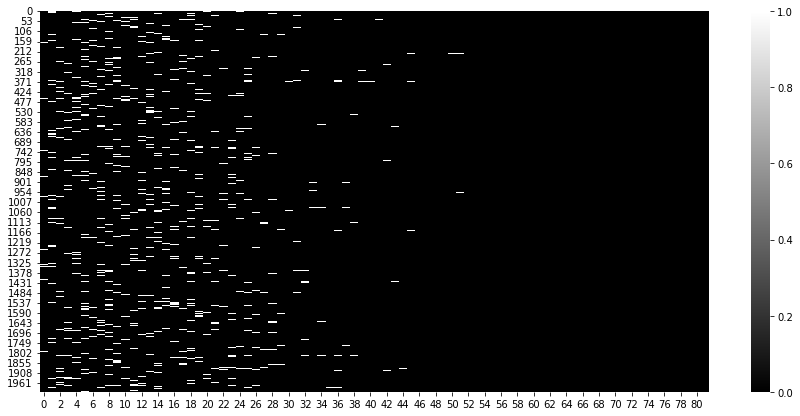

In [35]:
plt.figure(figsize=(15, 7))
sns.heatmap(val_oov_flag, cmap=plt.cm.binary_r);

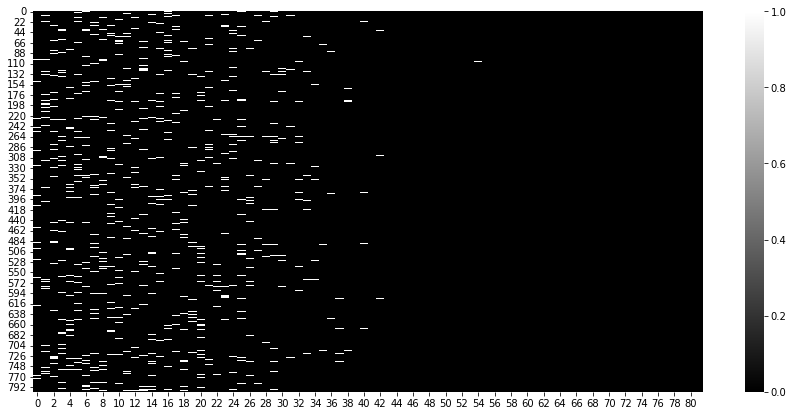

In [36]:
plt.figure(figsize=(15, 7))
sns.heatmap(test_oov_flag, cmap=plt.cm.binary_r);